In [2]:
import pickle
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import os
import math
import requests
import json
from datetime import datetime
from astropy.table import Table
from astropy.time import Time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib
import getpass
import warnings
import pandas
import time
import subprocess
import logging
import webbrowser
import glob
from datetime import *
import scipy.signal
from os import listdir
import sqlite3
from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum


np.random.seed(1)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [3]:
"""Read in the file containing a list of the sources you are interested in along with their redshifts, in two columns
    """

f = ascii.read("SLSNe - I copy.txt") #ascii file containing the names of sources and their redshifts
targets = f['col1']
redshift = f['col2']

In [4]:
import xlsxwriter

workbook = xlsxwriter.Workbook('results10.xlsx')
worksheet1 = workbook.add_worksheet()
worksheet2 = workbook.add_worksheet()

worksheet1.write(0, 0, 'Oxygen II')
worksheet1.write(0, 1, 'Velocity(normalized)(km/s)')
worksheet1.write(0, 2, 'Velocity_error(normalized)(km/s)')
worksheet1.write(0, 3, 'Velocity(original)(km/s)')
worksheet1.write(0, 4, 'Weighted_average_velocity(normalized)(km/s)')
worksheet1.write(0, 5, 'minima(Rest Wavelength)(Å)')
worksheet1.write(0, 6, 'minima_error(Rest Wavelength)(Å)')
worksheet1.write(0, 7, 'Equivalent_width(Å)')
worksheet1.write(0, 8, 'Equivalent_width_error(Å)')



worksheet2.write(0, 0, 'Oxygen II')
worksheet2.write(0, 1, 'Velocity(normalized)(km/s)')
worksheet2.write(0, 2, 'Velocity_error(normalized)(km/s)')
worksheet2.write(0, 3, 'Weighted_average_velocity(normalized)(km/s)')
worksheet2.write(0, 4, 'Velocity(original)(km/s)')
worksheet2.write(0, 5, 'Velocity_error(original)(km/s)')
worksheet2.write(0, 6, 'Weighted_average_velocity(original)(km/s)')
worksheet2.write(0, 7, 'minima(Rest Wavelength)(Å)')
worksheet2.write(0, 8, 'minima_error(Rest Wavelength)(Å)')
worksheet2.write(0, 9, 'Equivalent_width(Å)')
worksheet2.write(0, 10, 'Equivalent_width_error(Å)')
worksheet2.write(0, 11, 'Left_limit(Rest Wavelength)(Å)')
worksheet2.write(0, 12, 'Left_limit_error(Rest Wavelength)(Å)')
worksheet2.write(0, 13, 'Right_limit(Rest Wavelength)(Å)')
worksheet2.write(0, 14, 'Right_limit_error(Rest Wavelength)(Å)')


0

In [5]:
def fetch_ZTF_spectrum(target_id, user, passw, specfilter=False, program_idx=0):
    """Returns list of all available spectra(data url paths) for a given ZTF target.

    Input
    ------
    target_id: ZTF name of source (str)
    user: Username for login cridentials for GROWTH Marshall (str)
    passw: Password for login cridentials for GROWTH Marshall (str)
    specfilter: True; Choose a single spectrum based of of the peak magnitude (PM) (+7 days after PM or -4 before PM) (bool)
    specfilter: False; Choose multiple spectra uploaded in the Marshall (bool)

    Output
    ------
    list_spec: List of download paths (from marshall) in format: spectra/data/ZTFid_date_inst_vn.ascii (list)
    """

    programidx = program_idx # Superluminous: 10
    r = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi', auth=(user, passw), data = {'programidx': str(programidx)})
    sources = json.loads(r.text) # preliminary information on CLU objects
    list_spec, sd, dat_url, dat_inst = [], [], [], []

    for i in enumerate(sources_clu):
        name = i[1]['name'] # name generated from marshall

        if name == target_id: # if you find the ZTF_id you have queried
            marsh_info = i[1] # fetch marshall information!
            s = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/source_summary.cgi', auth=(user, passw), data = {'sourceid': str(marsh_info['id'])})
            sourceDict = json.loads(s.text)

            # Spectral and Photometric information --
            spec = sourceDict['uploaded_spectra'] # information on spectroscopy
            photometry_info = sourceDict['uploaded_photometry'] # information on photometry

            N_spec = len(spec) # number of available spectra! -- check for uniqueness? [NOTE!]
            
            for spectra_path in spec:
                list_spec.append(str(spectra_path['datapath'])) # append datapaths...
            return (list_spec)

In [6]:
def download_spectra(data_path, target_id, date_dir_name, dtype='no_header'):
    """Downloads .ascii files from GROWTH Marshall for given ZTF object.

    Input
    -----
    data_path: Download URL from GROWTH Marshall -- usually called from Fetch_ZTF_Spectrum (str)
    target_id: ZTF name of source (str)
    date_dir_name: daving date directory you will be storing the downloaded files (str)
    dtype: data type you want for the ascii files. Usually no_header will not read the first row of the ascii file.

    Output
    ------
    Creates /spectra and /summary directories and downloads ascii file data path given.

    """
    # GROWTH Marshall url where data is available
    download_url = "http://skipper.caltech.edu:8080/growth-data/"

    # Complete path to url downloading data
    data_path_mod = data_path.split("/")[2].split('.')[0] #ZTFid_date_inst_vn

    try:
        # Stich final directories to the directory containing the data
        final_path_to_data = download_url + "spectra/data/" + data_path_mod + ".ascii"
        #print ("this is the final path --> ")
        #print (final_path_to_data)
    except:
        #print ("This file you have requested is not available!")
        return (None)

    # Make a new directory with the ZTF name
    bash1 = subprocess.run("mkdir data/%s/%s"%(date_dir_name, target_id), shell=True)
    bash2 = subprocess.run("mkdir data/%s/%s/spectra"%(date_dir_name, target_id), shell=True) # create the spectra dir in the ZTF target dir

    # Fetch data from custom url
    data = ascii.read("%s"%final_path_to_data, format=dtype)
    # clean from nan values
    rmv_nan = np.where(np.isnan([data['col1'], data['col2']]))
    data.remove_rows(rmv_nan[1]) # will remove NaN identified values!
    min_lambda = min(data['col1']) # minimum wavelength
    max_lambda = max(data['col1'])# maximum wavelength

    # Generally in this directory we will have: ".asii", ".output"
    download_spectrum = ascii.write(data, "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod), format=dtype)
    stored_spectrum = "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod)
    return (stored_spectrum)

In [7]:
def plot_smoothed_spectra(a, b, fig_name, constant = 25, low_xlim = 3000, up_xlim = 7000, low_ylim = -30, up_ylim = 30):
    
    """Returns a plot of all the spectra arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    a(required): index of the source in the list to start plotiing from (int)
    b(required): index of the source in the list to end plotiing at (int)
    fig_name(required): Name the pdf of the plot created (str)
    constant(Optional, Default value. = 25): adds a constant to the calculated flux, value changes for every spectrum to shift them down on the 
                                             Y axis, to avoid overlap, hange value for an even distribution about zero (int), default 20
    low_xlim(Optional, Default value. = 2000): lower limit of x-axis (int)
    up_xlim(Optional, Default value. = 7000): upper limit of x-axis (int)
    low_ylim(Optional, Default value. = -30): lower limit of y-axis (int)
    up_ylim"(Optional, Default value. = 30): upper limit of y-axis (int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """


    plotx = []
    ploty = []

    label = [[],[]]
    text = []

    rest = []
    instrument = np.array([])
    datesss = []
    instrument_sorted = np.array([])
    mistake = []

    for t in targets[a:b]: # Go through the list of ZTFnames in the ascii file
        print (t)

        directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

        for d in directory: # go through all the spectra for a single source
            
            #print (d)

            l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
            #print (l)    
            mistake.append(l)

            inst = l.split("_")[2]
            instrument=np.append(instrument,inst)

            date = l.split("_")[1]      # store just the date from the spectrum name
             

            new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
            #print (new_date)  

            normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

            Julian_date = normal_date.mjd #convert to MJD
            #print(Julian_date)
            datesss.append(Julian_date)

            label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
            #print (label)    

            text.append(label)    #append all the labels to an array to use later
            #text.append(label)

            data = ascii.read(d)    #read in the ascii file
            data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

            # Removing all the rows where either of the values is nan
            data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
            data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

            #Scaling the flux values here
            lam_cut = np.where((data_l>6000) & (data_l<7000))

            #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
            mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

            plotx.append(data_l)
            ploty.append(data_flux/mean) #Scaling flux for plotting

        b = (np.argsort (datesss))

        #print (instrument)

        sorting = np.array(instrument[b])
        #print (sorting)
        instrument_sorted = np.append (instrument_sorted,sorting)
    
    #print(instrument)
    #print (instrument_sorted)

    fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,20))
    ax.set_xlim(low_xlim,up_xlim)
    ax.set_ylim(low_ylim,up_ylim)
    plt.xlabel('Rest Wavelength Å')
    plt.ylabel('Scaled Flux + Constant')
    #plt.yscale('log')

    const = constant  #increment
    count = 0 #increment
    inc = 0
    name = fig_name

    
    for k in zip(plotx,ploty):

        #print(np.array(instrument_sorted[inc]))

        if instrument_sorted[inc] == "Keck1": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) #Fit smoothed spectra using Savitzky-Golay filter

        elif instrument_sorted[inc] == "Keck2": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        elif instrument_sorted[inc] == "P200":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "P60":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)

        elif instrument_sorted[inc] == "LT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)

        elif instrument_sorted[inc] == "NOT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        elif instrument_sorted[inc] == "VLT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "DCT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "WHT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "NTT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        # Plotting the spectrum name and date for every spectrum
        y_temp = k[1] + const   # Scaling flux values and saving in a temporary variable
        text_pos_y = np.median(y_temp)    # defining the location on y-axis
        ax.text((up_xlim+200), (text_pos_y), text[count], size=12) 

        #print (text[count])
        variable = text[count][0]    # Only select the name of sourcec by indexing
        #print (variable)
        r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
        z = (1 + r)

        ax.plot(k[0]/z, k[1]+const,  color = '0.7')   #Plotting the x in rest wavelength and y in scaled flux + const  
        ax.plot(k[0]/z, yhat+const, color='red')    #Plotting the x in rest wavelength and y in smoothed spectra + const

        inc += 1
        count = count+1  #to go through the Text array and print appropriate text besides every spectra
        const += -2    #shift the spectra


    # Make a new directory to save the plots   
    bash1 = subprocess.run("mkdir plots", shell=True)    
    plt.savefig("plots/%s"%name, format = 'pdf', bbox_inches = 'tight')
    plt.show()

In [8]:
def plot_spectra(a, b, fig_name, constant = 25, low_xlim = 3000, up_xlim = 7000, low_ylim = -30, up_ylim = 30):
    
    """Returns a plot of all the spectra arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    a(required): index of the source in the list to start plotiing from (int)
    b(required): index of the source in the list to end plotiing at (int)
    fig_name(required): Name the pdf of the plot created (str)
    constant(Optional, Default value. = 25): adds a constant to the calculated flux, value changes for every spectrum to shift them down on the 
                                             Y axis, to avoid overlap, hange value for an even distribution about zero (int), default 20
    low_xlim(Optional, Default value. = 2000): lower limit of x-axis (int)
    up_xlim(Optional, Default value. = 7000): upper limit of x-axis (int)
    low_ylim(Optional, Default value. = -30): lower limit of y-axis (int)
    up_ylim"(Optional, Default value. = 30): upper limit of y-axis (int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """


    plotx = []
    ploty = []

    label = [[],[]]
    text = []

    rest = []
    instrument = np.array([])
    datesss = []
    instrument_sorted = np.array([])
    mistake = []

    for t in targets[a:b]: # Go through the list of ZTFnames in the ascii file
        print (t)

        directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

        for d in directory: # go through all the spectra for a single source
            
            #print (d)

            l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
            #print (l)    
            mistake.append(l)

            inst = l.split("_")[2]
            instrument=np.append(instrument,inst)

            date = l.split("_")[1]      # store just the date from the spectrum name
             

            new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
            #print (new_date)  

            normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

            Julian_date = normal_date.mjd #convert to MJD
            #print(Julian_date)
            datesss.append(Julian_date)

            label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
            #print (label)    

            text.append(label)    #append all the labels to an array to use later
            #text.append(label)

            data = ascii.read(d)    #read in the ascii file
            data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

            # Removing all the rows where either of the values is nan
            data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
            data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

            #Scaling the flux values here
            lam_cut = np.where((data_l>6000) & (data_l<7000))

            #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
            mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

            plotx.append(data_l)
            ploty.append(data_flux/mean) #Scaling flux for plotting
            

    fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,20))
    ax.set_xlim(low_xlim,up_xlim)
    ax.set_ylim(low_ylim,up_ylim)
    plt.xlabel('Rest Wavelength Å')
    plt.ylabel('Scaled Flux + Constant')
    #plt.yscale('log')

    const = constant  #increment
    count = 0 #increment
    inc = 0
    name = fig_name

    #print (text)
    #print (instrument)
    
    for k in zip(plotx,ploty):
        
        #print(instrument[inc])
        #print(text[inc])
        
        if instrument[inc] == "Keck1": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) #Fit smoothed spectra using Savitzky-Golay filter

        if instrument[inc] == "Keck2": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        if instrument[inc] == "P200":
            yhat = scipy.signal.savgol_filter(k[1], 81, 3)

        if instrument[inc] == "P60":
            yhat = scipy.signal.savgol_filter(k[1], 21, 4)

        if instrument[inc] == "LT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)

        if instrument[inc] == "NOT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        if instrument[inc] == "VLT":
            yhat = scipy.signal.savgol_filter(k[1], 81, 3)

        if instrument[inc] == "DCT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        if instrument[inc] == "WHT":
            yhat = scipy.signal.savgol_filter(k[1], 81, 3)

        if instrument[inc] == "NTT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)
            

        # Plotting the spectrum name and date for every spectrum
        y_temp = k[1] + const   # Scaling flux values and saving in a temporary variable
        text_pos_y = np.median(y_temp)    # defining the location on y-axis
        ax.text((up_xlim+200), (text_pos_y), text[inc], size=12) 

        #print (text[count])
        variable = text[inc][0]    # Only select the name of sourcec by indexing
        #print (variable)
        r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
        #print (r)
        z = (1 + r)

        ax.plot(k[0]/z, k[1]+const,  color = '0.7')   #Plotting the x in rest wavelength and y in scaled flux + const  
        ax.plot(k[0]/z, yhat+const, color='red')    #Plotting the x in rest wavelength and y in smoothed spectra + const

        inc += 1
        count = count+1  #to go through the Text array and print appropriate text besides every spectra
        const += -2    #shift the spectra


    # Make a new directory to save the plots   
    bash1 = subprocess.run("mkdir plots", shell=True)    
    plt.savefig("plots/%s"%name, format = 'pdf', bbox_inches = 'tight')
    plt.show()

ZTF18abszecm
ZTF18acenqto
ZTF18acxgqxq
ZTF19aarphwc
ZTF19aawsqsc


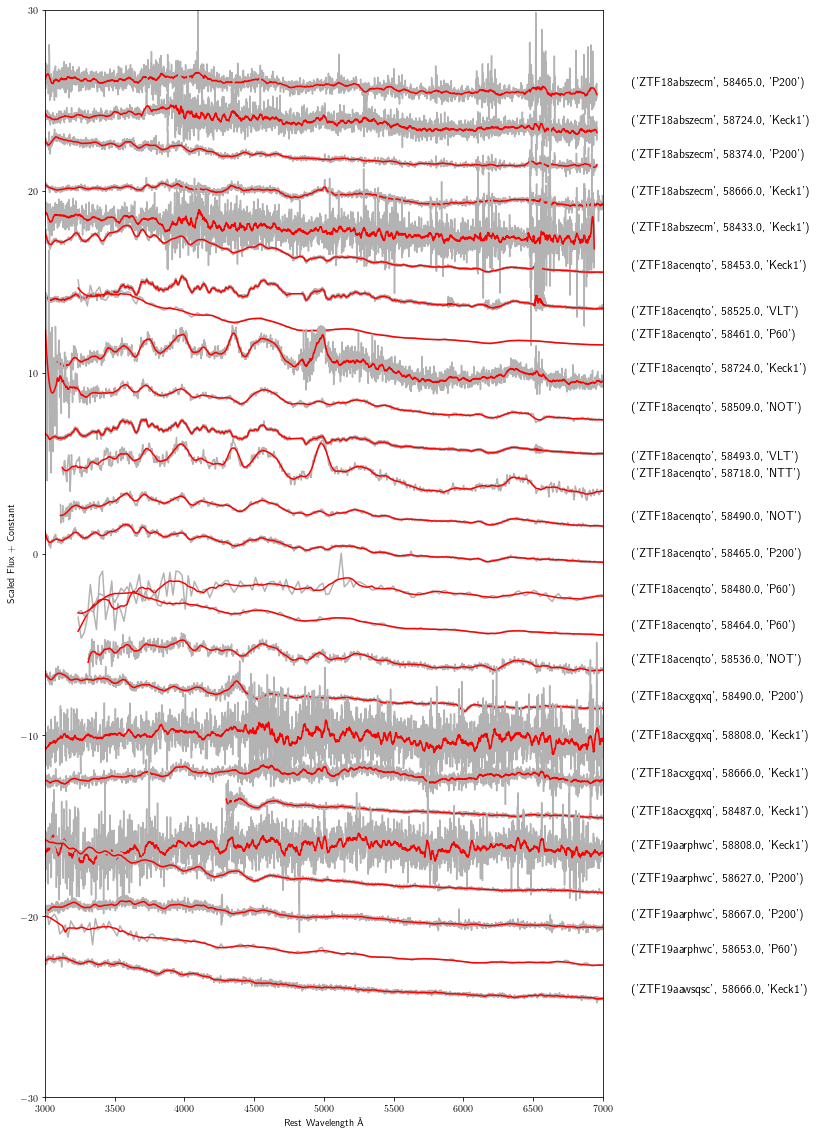

In [81]:
plot_spectra(0, 5, "trial1")

ZTF19aavouyw
ZTF19aaqrime
ZTF19abaeyqw
ZTF18aajqcue
ZTF18aavrmcg


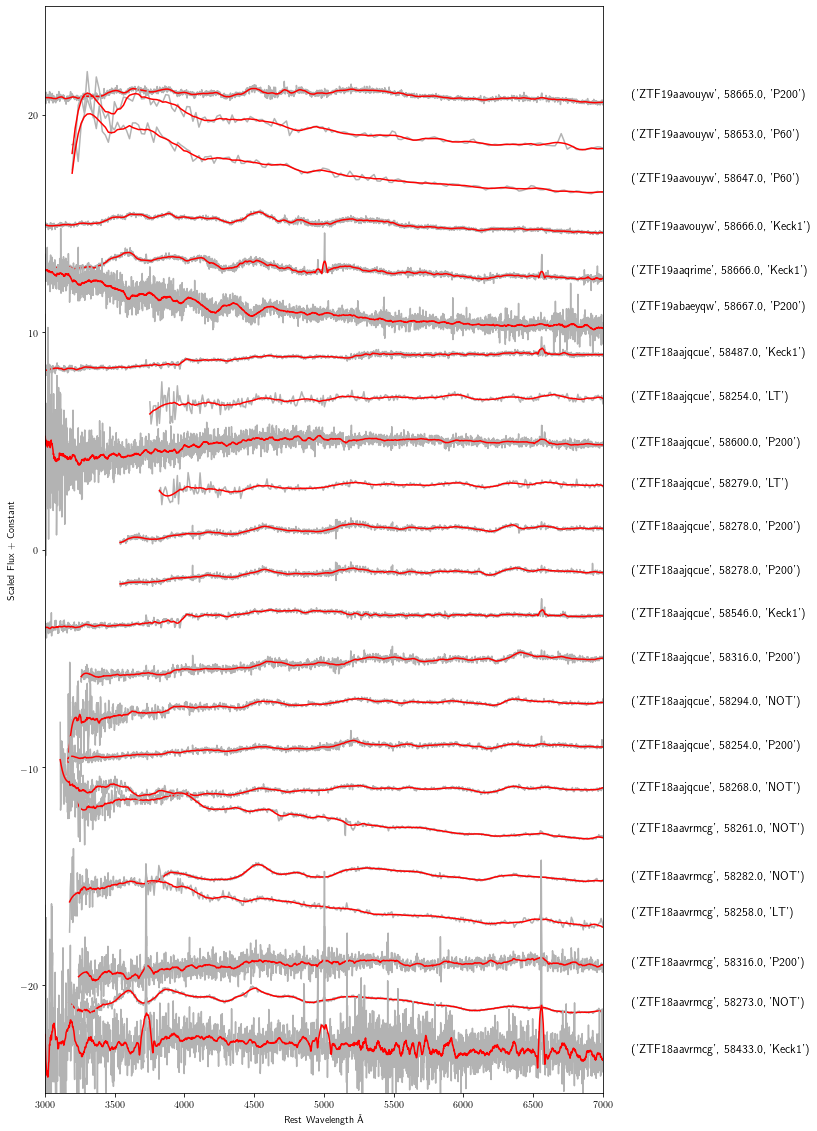

In [8]:
plot_spectra(5, 10, "trial2", 20, 3000, 7000, -25, 25)

ZTF18aazgrfl
ZTF18abjwagv
ZTF18ablwafp
ZTF18abmasep
ZTF18abshezu


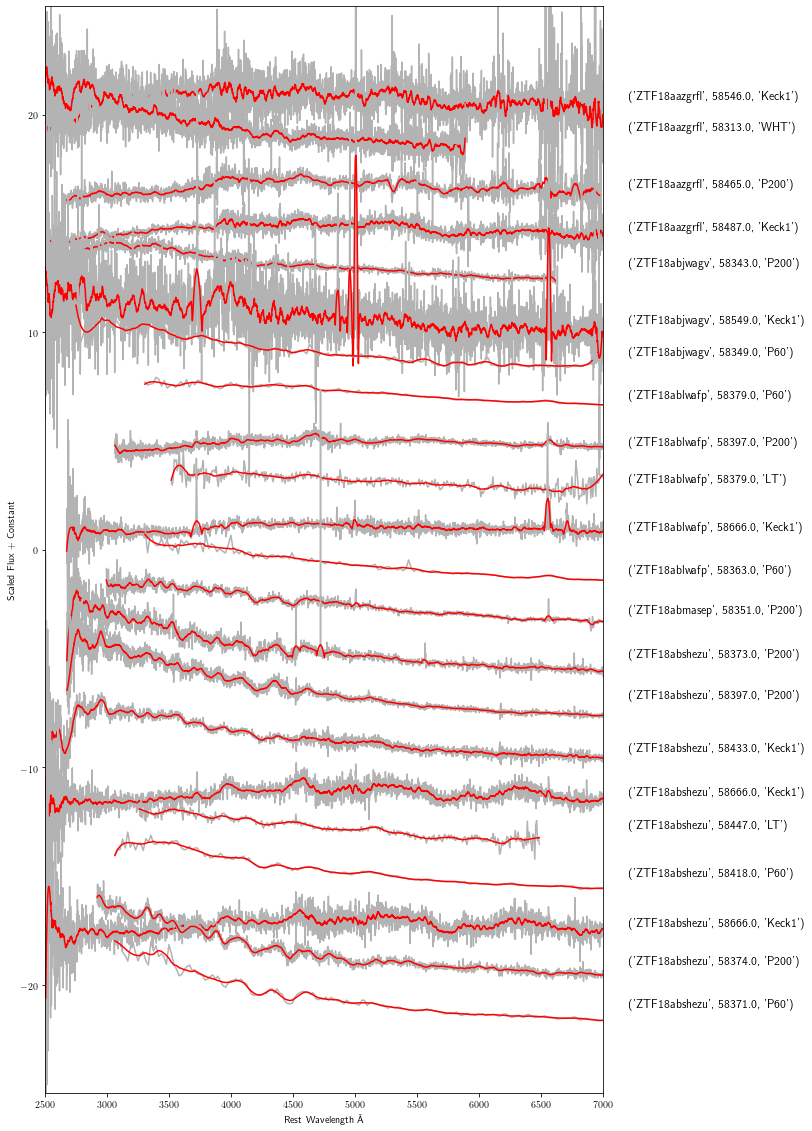

In [9]:
plot_spectra(10, 15, "Trial3", 20, 2500, 7000, -25, 25)

ZTF18abvgjyl
ZTF18acapyww
ZTF18achdidy
ZTF18acqyvag
ZTF18acslpji


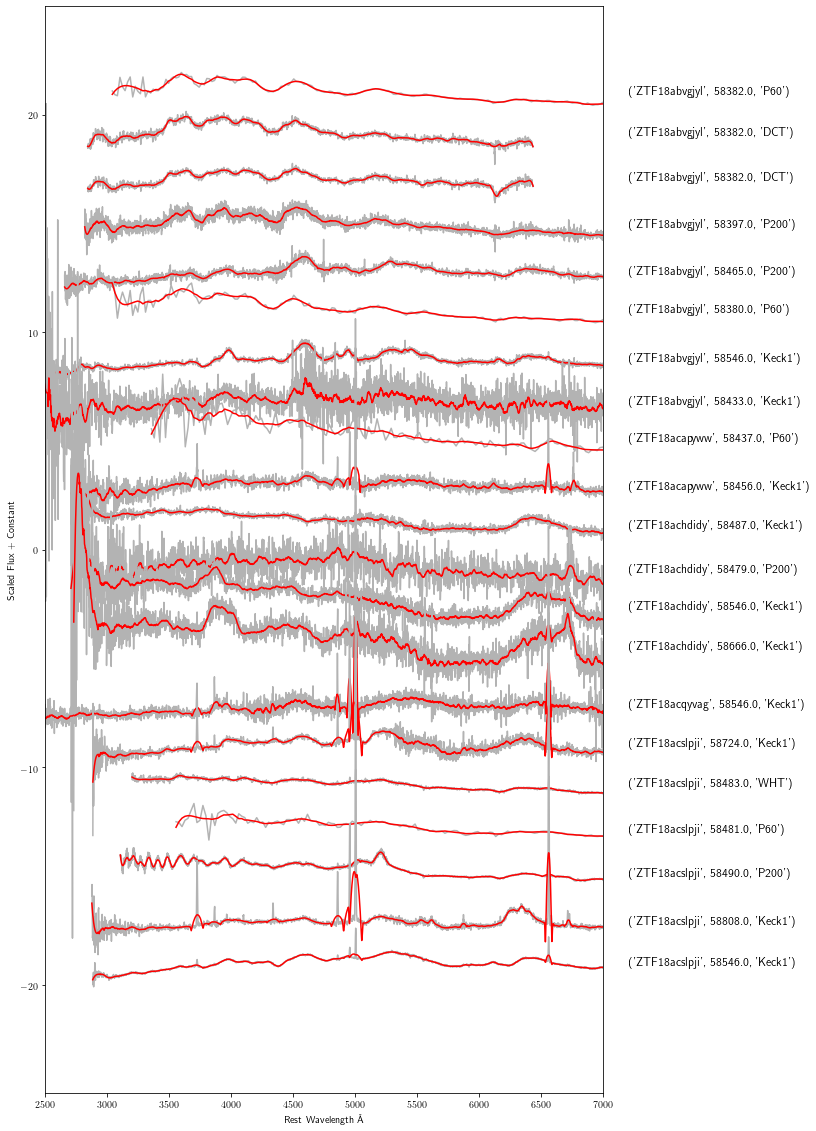

In [10]:
plot_spectra(15, 20, "Trial4", 20, 2500, 7000, -25, 25)

ZTF18acyxnyw
ZTF19aacxrab
ZTF19aajwogx
ZTF19aaknqmp
ZTF19aalbrph


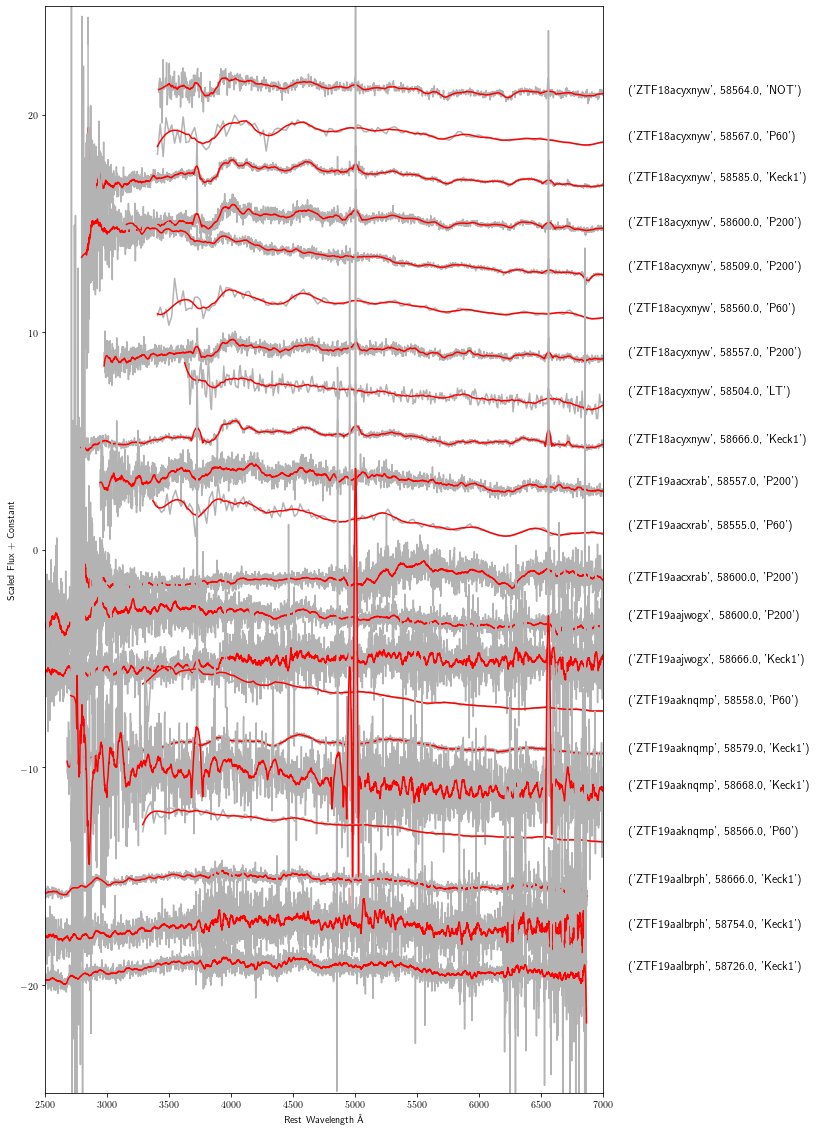

In [11]:
plot_spectra(20, 25, "Trial5", 20, 2500, 7000, -25, 25)

ZTF19aamhhiz
ZTF19aantokv
ZTF19aaohuwc
ZTF19aapaeye
ZTF19aaruixj
ZTF19aasdvfr
ZTF19aauiref
ZTF19aayclnm
ZTF19abdlzyq
ZTF19abfvnns


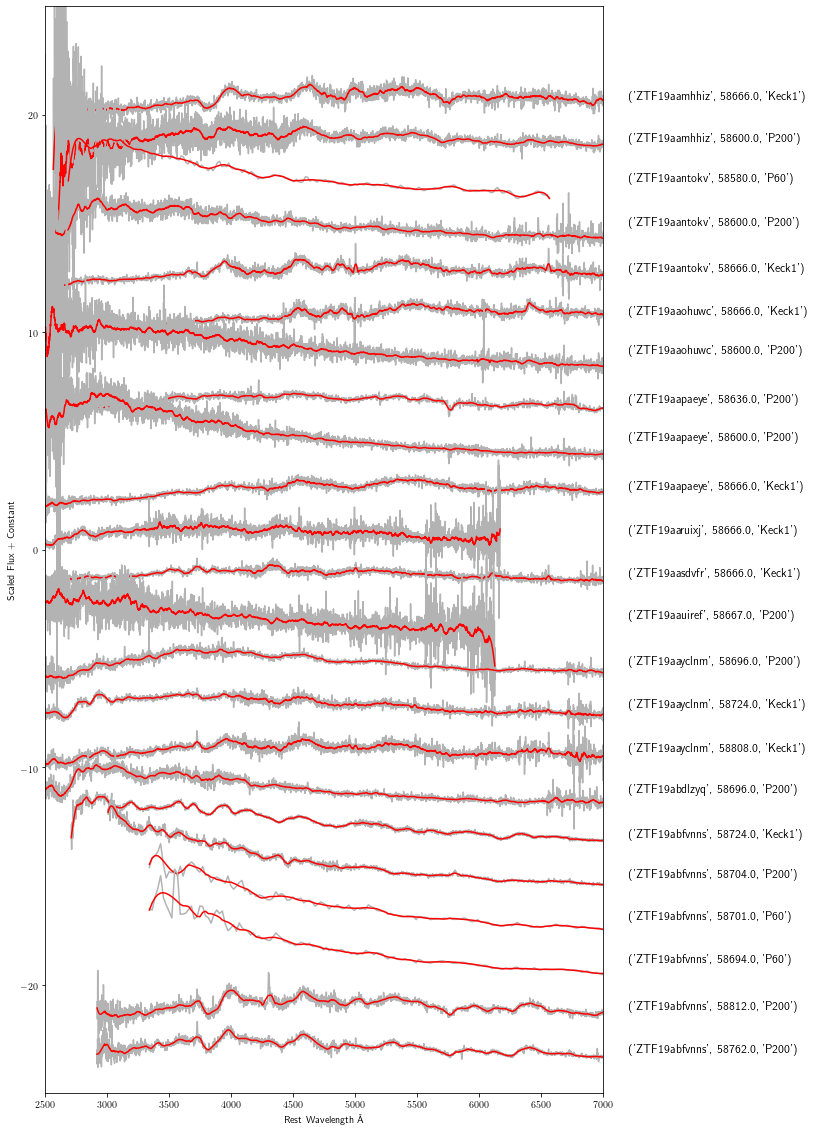

In [12]:
plot_spectra(25, 36, "Trial6", 20, 2500, 7000, -25, 25)

In [9]:
def normalize_spectra(target_name, spec, row, O1, O2, O3, O4, O5, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):
    
    
    """Returns a plot of the spectrum with absorbtion features marked for  arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    target_name (required): Name of the target from the list you are interested in (str)
    spec (required): Name of the particular specrtum for which you need the velocity and equivalent width (str)
    row (required): numer of the row where you want to start writing the output on the excel sheet. add '7' to the previous row number for every new candidate
    
    O1 (required): estimate wavelenth in rest frame of first feature(int)
    O2 (required): estimate wavelenth in rest frame of second feature(int)
    O3 (required): estimate wavelenth in rest frame of third feature(int)
    O4 (required): estimate wavelenth in rest frame of fourth feature(int)
    O5 (required): estimate wavelenth in rest frame of fifth feature(int)
    
    R1 (Optional, Deault value = 3727.59): Theoretical Rest wavelenth  of first feature(int)
    R2 (Optional, Deault value = 3959.83): Theoretical Rest wavelenth  of second feature(int)
    R3 (Optional, Deault value = 4115.17): Theoretical Rest wavelenth of third feature(int)
    R4 (Optional, Deault value = 4375.97): Theoretical Rest wavelenth of fourth feature(int)
    R5 (Optional, Deault value = 4650.71): Theoretical Rest wavelenth of fifth feature(int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []
    
    vel = []
    mini = []

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):
                    
                    #print(d)

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string   

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name   

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18" 

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting


            flux = np.array([])
            wavelength = np.array([])

            fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))

            ax.set_xlim(3000,5000)
            ax.set_ylim(-1,3)
            ax.set_xlabel('Rest Wavelength Å')
            ax.set_ylabel('Normalized Scaled Flux')

            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

                print("\n", text[count])

                y_temp = k[1]   # Scaling flux values and saving in a temporary variable
                text_pos_y = np.median(y_temp)    # defining the location on y-axis
                ax.text(5200, (text_pos_y), text[count], size=12)
                
                plt.axvline(R1, color = 'green')
                plt.axvline(R2, color = 'green')
                plt.axvline(R3, color = 'green')
                plt.axvline(R4, color = 'green')
                plt.axvline(R5, color = 'green')

                variable = text[count][0]    # Only select the name of sourcec by indexing

                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                spectrum = Spectrum1D(flux = k[1]* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (k[0]/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((k[0]/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat = scipy.signal.savgol_filter(spec_normalized.flux, 101, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis
                
                if O1 == 0:
                    pass
                
                else:

                    O1 = np.where ((wavelength > (O1 - 50)*u.Angstrom) & (wavelength < (O1 + 50)*u.Angstrom))

                    O1_flux = min(yhat[O1])
                    O1_index = np.where(yhat == O1_flux)
                    O1_min = wavelength[O1_index]
                    O1_min2 = k[0][O1_index]
                    #print ("Rest_1: %s"%O1_min)
                    #print ("Observed_1: %s"%O1_min2)

                    velocity1 = (abs(O1_min - (3727.59*u.Angstrom))/(3727.59*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_1: %s,"%O1_min, "Velocity1 is : %s km/s"%velocity1)
                    
                    vel.append(velocity1)
                    mini.append(O1_min)
                    
                
                if O2 == 0:
                    pass
                
                else:
    

                    O2 = np.where ((wavelength >  (O2 - 50)*u.Angstrom) & (wavelength < (O2 + 50)*u.Angstrom))

                    O2_flux = min(yhat[O2])
                    O2_index = np.where(yhat == O2_flux)
                    O2_min = wavelength[O2_index]
                    O2_min2 = k[0][O2_index]
                    #print ("Rest_2: %s"%O2_min)
                    #print ("Observed_2: %s"%O2_min2)

                    velocity2 = (abs(O2_min - (3959.83*u.Angstrom))/(3959.83*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_2: %s,"%O2_min, "Velocity2 is : %s km/s"%velocity2)
                    
                    vel.append(velocity2)
                    mini.append(O2_min)
                    
                
                if O3 == 0:
                    pass
                
                else:

                
                    #O3 = np.where ((wavelength >  3970*u.Angstrom) & (wavelength < 4120*u.Angstrom))
                    O3 = np.where ((wavelength >  (O3 - 50)*u.Angstrom) & (wavelength < (O3 + 50)*u.Angstrom))

                    O3_flux = min(yhat[O3])
                    O3_index = np.where(yhat == O3_flux)
                    O3_min = wavelength[O3_index]
                    O3_min2 = k[0][O3_index]
                    #print ("Rest_3: %s"%O3_min)
                    #print ("Observed_3: %s"%O3_min2) 

                    velocity3 = (abs(O3_min - (4115.17*u.Angstrom))/(4115.17*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_3: %s,"%O3_min, "Velocity3 is : %s km/s"%velocity3)
                    
                    vel.append(velocity3)
                    mini.append(O3_min)
                    
                    
                if O4 == 0:
                    pass
                
                else:


                    O4 = np.where ((wavelength >  (O4 - 50)*u.Angstrom) & (wavelength < (O4 + 50)*u.Angstrom))

                    O4_flux = min(yhat[O4])
                    O4_index = np.where(yhat == O4_flux)
                    O4_min = wavelength[O4_index]
                    O4_min2 = k[0][O4_index]
                    #print ("Rest_4: %s"%O4_min)
                    #print ("Observed_4: %s"%O4_min2) 

                    velocity4 = (abs(O4_min - (4375.97*u.Angstrom))/(4375.97*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_4: %s,"%O4_min, "Velocity4 is : %s km/s"%velocity4)
                    
                    vel.append(velocity4)
                    mini.append(O4_min)
                    
                    
                if O5 == 0:
                    pass
                
                else:


                    O5 = np.where ((wavelength >  (O5 - 50)*u.Angstrom) & (wavelength < (O5 + 50)*u.Angstrom))

                    O5_flux = min(yhat[O5])
                    O5_index = np.where(yhat == O5_flux)
                    O5_min = wavelength[O5_index]
                    O5_min2 = k[0][O5_index]
                    #print ("Rest_4: %s"%O5_min)
                    #print ("Observed_4: %s"%O5_min2) 


                    velocity5 = (abs(O5_min - (4650*u.Angstrom))/(4650*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_5: %s,"%O5_min, "Velocity5 is : %s km/s"%velocity5)
                    
                    vel.append(velocity5)
                    mini.append(O5_min)
                
                
                
                velocities = np.array(vel)
                minimums = np.array(mini)
                
                
                plt.plot(spec_normalized.spectral_axis, spec_normalized.flux, color ='lightblue')
                ax.plot(k[0]/z, yhat, color='darkblue')    #Plotting the x in rest wavelength and y in smoothed spectra + const
                 
                for i in range (len(velocities)):
                    
                    row += 1
                    
                    worksheet1.write(row, 0, 'Feature_%s' %(i+1))
                    worksheet2.write(row, 0, 'Feature_%s' %(i+1))
                    
                    worksheet1.write(row, 1, velocities[i])
                    worksheet2.write(row, 1, velocities[i])
                    
                    worksheet1.write(row, 5, minimums[i])
                    worksheet2.write(row, 7, minimums[i])
                    

                for i in range (len(minimums)):
                
                    plt.axvline(minimums[i], color = 'orange')
                    
                    
                inc += 1
                count = count+1  #to go through the Text array and print appropriate text besides every spectra

                bash1 = subprocess.run("mkdir plots", shell=True) 
                plt.savefig("plots/%s_normalized"%spec.split(".")[0], format = 'pdf', bbox_inches = 'tight')
                plt.show()
                

In [10]:
def equivalent_width(target_name, spec, row, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max):
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []
    
    ew = []
    mini = []
    maxi = []

    #target_name = "ZTF19aarphwc"
    #spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d ==  "data/new/%s/spectra/%s"%(target_name,spec):
                    
                    #print(d)

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name
                    #print (date)     

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
                    #print (new_date)  

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
                    #print (label)    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting

            #print (instrument)

            flux = np.array([])
            wavelength = np.array([])

            const = 0   #increment
            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

    
                #print (text[count])
                variable = text[count][0]    # Only select the name of sourcec by indexing
              
                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                spectrum = Spectrum1D(flux = k[1]* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (k[0]/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((k[0]/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis
                
                if O1_min == 0:
                    pass
                
                else:

                    L1min = np.where ((wavelength > (O1_min - 50)*u.Angstrom) & (wavelength < (O1_min + 50)*u.Angstrom))
                    L1min_flux = max(yhat[L1min])
                    L1min_index = np.where(yhat == L1min_flux)
                    L1min_rest = wavelength[L1min_index]
                    L1min_observed = k[0][L1min_index]
                    #print ("\n\n Rest_L1min: %s"%L1min_rest)
                    #print ("Observed_L1min: %s"%L1min_observed)
                    
                    mini.append(L1min_rest)
                
                if O1_max == 0:
                    pass
                
                else:

                    L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                    L1max_flux = max(yhat[L1max])
                    L1max_index = np.where(yhat == L1max_flux)
                    L1max_rest = wavelength[L1max_index]
                    L1max_observed = k[0][L1max_index]
                    #print (" Rest_L1max: %s"%L1max_rest) 
                    #print ("Observed_L1max: %s"%L1max_observed)

                    pEW1_rest = L1max_rest - L1min_rest
                    pEW1_observed = L1max_observed - L1min_observed
                    
                    maxi.append(L1max_rest)
                    ew.append(pEW1_rest)
                    
                    print ("Eqivalent width for O1 is %s" %pEW1_rest)
                    #print ("Eqivalent width for O1 from observed is %s" %pEW1_observed)
                    
                
                if O2_min == 0:
                    pass
                
                else:

                    L2min = np.where ((wavelength >  (O2_min - 50)*u.Angstrom) & (wavelength < (O2_min + 50)*u.Angstrom))
                    L2min_flux = max(yhat[L2min])
                    L2min_index = np.where(yhat == L2min_flux)
                    L2min_rest = wavelength[L2min_index]
                    L2min_observed = k[0][L2min_index]
                    #print ("\n\n Rest_L2min: %s"%L2min_rest)
                    #print ( "Observed_L2min: %s"%L2min_observed)
                    
                    mini.append(L2min_rest)

                
                if O2_max == 0:
                    pass
                
                else:

                    L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                    L2max_flux = max(yhat[L2max])
                    L2max_index = np.where(yhat == L2max_flux)
                    L2max_rest = wavelength[L2max_index]
                    L2max_observed = k[0][L2max_index]
                    #print (" Rest_L2max: %s"%L2max_rest) 
                    #print ( "Observed_L2max: %s"%L2max_observed)

                    pEW2_rest = L2max_rest - L2min_rest
                    pEW2_observed = L2max_observed - L2min_observed
                    
                    maxi.append(L2max_rest)
                    ew.append(pEW2_rest)

                    print ("Eqivalent width for O2 is %s" %pEW2_rest) 
                    #print ( "Eqivalent width for O2 from observed is %s" %pEW2_observed)
                    
                    
                if O3_min == 0:
                    pass
                
                else:

                    L3min = np.where ((wavelength >  (O3_min - 50)*u.Angstrom) & (wavelength < (O3_min + 50)*u.Angstrom))
                    L3min_flux = max(yhat[L3min])
                    L3min_index = np.where(yhat == L3min_flux)
                    L3min_rest = wavelength[L3min_index]
                    L3min_observed = k[0][L3min_index]
                    #print ("\n\n Rest_L3min: %s"%L3min_rest)
                    #print ( "Observed_L3min: %s"%L3min_observed)
                    
                    mini.append(L3min_rest)
                    
                
                if O3_max == 0:
                    pass
                
                else:

                    L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                    L3max_flux = max(yhat[L3max])
                    L3max_index = np.where(yhat == L3max_flux)
                    L3max_rest = wavelength[L3max_index]
                    L3max_observed = k[0][L3max_index]
                    #print (" Rest_L3max: %s"%L3max_rest)
                    #print ( "Observed_L3max: %s"%L3max_observed)

                    pEW3_rest = L3max_rest - L3min_rest
                    pEW3_observed = L3max_observed - L3min_observed
                    
                    maxi.append(L3max_rest)
                    ew.append(pEW3_rest)

                    print ("Eqivalent width for O3 is %s" %pEW3_rest)
                    #print ("Eqivalent width for O3 from observed is %s" %pEW3_observed)
                    
                    
                if O4_min == 0:
                    pass
                
                else:
                    

                    L4min = np.where ((wavelength >  (O4_min - 50)*u.Angstrom) & (wavelength < (O4_min + 50)*u.Angstrom))
                    L4min_flux = max(yhat[L4min])
                    L4min_index = np.where(yhat == L4min_flux)
                    L4min_rest = wavelength[L4min_index]
                    L4min_observed = k[0][L4min_index]
                    #print ("\n\n Rest_L4min: %s"%L4min_rest)
                    #print ("Observed_L4min: %s"%L4min_observed)
                    
                    mini.append(L4min_rest)
                    
                    
                if O4_max == 0:
                    pass
                
                else:
                    
                    L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                    L4max_flux = max(yhat[L4max])
                    L4max_index = np.where(yhat == L4max_flux)
                    L4max_rest = wavelength[L4max_index]
                    L4max_observed = k[0][L4max_index]
                    #print (" Rest_L4max: %s"%L4max_rest)
                    #print ("Observed_L4max: %s"%L4max_observed)

                    pEW4_rest = L4max_rest - L4min_rest
                    pEW4_observed = L4max_observed - L4min_observed
                    
                    maxi.append(L4max_rest)
                    ew.append(pEW4_rest)

                    print ("Eqivalent width for O4 is %s" %pEW4_rest)
                    #print ("Eqivalent width for O4 from observed is %s" %pEW4_observed)

                
                
                if O5_min == 0:
                    pass
                
                else:
                
                    L5min = np.where ((wavelength >  (O5_min - 50)*u.Angstrom) & (wavelength < (O5_min + 50)*u.Angstrom))
                    L5min_flux = max(yhat[L5min])
                    L5min_index = np.where(yhat == L5min_flux)
                    L5min_rest = wavelength[L5min_index]
                    L5min_observed = k[0][L5min_index]
                    #print ("\n\n Rest_L5min: %s"%L5min_rest)
                    #print ("Observed_L5min: %s"%L5min_observed)
                    
                    mini.append(L5min_rest)
                    
                if O5_max == 0:
                    pass
                
                else:

                    L5max = np.where ((wavelength > (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                    L5max_flux = max(yhat[L5max])
                    L5max_index = np.where(yhat == L5max_flux)
                    L5max_rest = wavelength[L5max_index]
                    L5max_observed = k[0][L5max_index]
                    #print (" Rest_L5max: %s"%L5max_rest)
                    #print ("Observed_L5max: %s"%L5max_observed)

                    pEW5_rest = L5max_rest - L5min_rest
                    pEW5_observed = L5max_observed - L5min_observed
                    
                    maxi.append(L5max_rest)
                    ew.append(pEW5_rest)

                    print ("Eqivalent width for O5 is %s" %pEW5_rest)
                    #print ("Eqivalent width for O5 from observed is %s" %pEW5_observed)
                
                equivalent_width = np.array(ew)
                left_limit = np.array(mini)
                right_limit = np.array(maxi)
                
                for i in range (len(left_limit)):
                    
                    row += 1
                    
                    worksheet1.write(row, 7, equivalent_width[i])
                    worksheet2.write(row, 9, equivalent_width[i])
                    

                    worksheet2.write(row, 11, left_limit[i])
                    worksheet2.write(row, 13, right_limit[i])
                    

In [11]:
def errors(target_name, spec, row, O1, O2, O3, O4, O5, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):

    for t in targets:

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):
                    
                    #print (d)

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    variable = l.split("_")[0]

                    r = redshift[np.where(variable == targets)]
                    z = 1 + r 

                    data = ascii.read(d)    #read in the ascii file

                    spectrum = Spectrum1D(flux =  data['col2']* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (data['col1']/z)*u.Angstrom)

                    g1_fit = fit_generic_continuum(spectrum)

                    y_continuum_fitted = g1_fit((data['col1']/z)* u.Angstrom)

                    spec_normalized = spectrum / y_continuum_fitted
                    yhat_1 = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                    flux = spec_normalized.flux
                    wavelength = spec_normalized.spectral_axis


                    y_new =  flux - yhat_1

                    #print (y_new)

                    mean = np.median(y_new, axis = 0)
                    std = np.std(y_new, axis = 0)

                    #print (mean, std)

                    N_samples = 1000#number of random samples to draw for each x value

                    shape = len(wavelength)

                    y_array = np.zeros( (N_samples, shape) ) #Spectrum 1

                    velocity1_arr = ( [] )
                    velocity2_arr = ( [] )
                    velocity3_arr = ( [] )
                    velocity4_arr = ( [] )
                    velocity5_arr = ( [] )

                    Rest_min1_arr = ( [] )
                    Rest_min2_arr = ( [] )
                    Rest_min3_arr = ( [] )
                    Rest_min4_arr = ( [] )
                    Rest_min5_arr = ( [] )

                    Observed_min1_arr = ([])
                    Observed_min2_arr = ([])
                    Observed_min3_arr = ([])
                    Observed_min4_arr = ([])
                    Observed_min5_arr = ([])

                    Rest_L1min_arr = []
                    Rest_L2min_arr = []
                    Rest_L3min_arr = []
                    Rest_L4min_arr = []
                    Rest_L5min_arr = []

                    Rest_L1max_arr = []
                    Rest_L2max_arr = []
                    Rest_L3max_arr = []
                    Rest_L4max_arr = []
                    Rest_L5max_arr = []

                    Observed_L1min_arr = ([])
                    Observed_L2min_arr = ([])
                    Observed_L3min_arr = ([])
                    Observed_L4min_arr = ([])
                    Observed_L5min_arr = ([])

                    Observed_L1max_arr = ([])
                    Observed_L2max_arr = ([])
                    Observed_L3max_arr = ([])
                    Observed_L4max_arr = ([])
                    Observed_L5max_arr = ([])

                    Equivalent_width_Rest1 = []
                    Equivalent_width_Rest2 = []
                    Equivalent_width_Rest3 = []
                    Equivalent_width_Rest4 = []
                    Equivalent_width_Rest5 = []

                    Equivalent_width_Observed1 = []
                    Equivalent_width_Observed2 = []
                    Equivalent_width_Observed3 = []
                    Equivalent_width_Observed4 = []
                    Equivalent_width_Observed5 = []

                    #fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))
                    #plt.plot(wavelength, y_new, color ='0.7')


                    for i in range(N_samples):

                        #plt.xlim(3000,5000)
                        noise = np.random.normal(0, 0.1, len(yhat_1))

                        y = yhat_1 + noise

                        y_array[i] =  y

                        #plt.plot(wavelength, y_array[i])

                        yhat = scipy.signal.savgol_filter(y_array[i], 51, 3)
                        
                        if O1 == 0:
                            pass
                
                        else:

                            O1_new = np.where ((wavelength >  (O1-50)*u.Angstrom) & (wavelength < (O1+50)*u.Angstrom))
                            O1_flux = min(yhat[O1_new])
                            O1_index = np.where(yhat == O1_flux)
                            O1_min = wavelength[O1_index]
                            O1_min2 = wavelength[O1_index]*z

                            velocity1 = (abs(O1_min - (R1*u.Angstrom))/(R1*u.Angstrom))*(3*pow(10,5))
                            velocity1_arr = np.append(velocity1_arr, velocity1)

                            Rest_min1_arr.append(O1_min)
                            Observed_min1_arr.append(O1_min2)

                            #print ("Rest_1: %s,"%O1_min, "Observed_1: %s,"%O1_min2, "Velocity is : %s km/s"%velocity1)
                            #print (velocity1)
                            #print (np.mean(velocity1_arr))
                            
                            
                        
                        if O2 == 0:
                            pass
                
                        else:

                            O2_new = np.where ((wavelength >  (O2-50)*u.Angstrom) & (wavelength < (O2+50)*u.Angstrom))
                            O2_flux = min(yhat[O2_new])
                            O2_index = np.where(yhat == O2_flux)
                            O2_min = wavelength[O2_index]
                            O2_min2 = wavelength[O2_index]*z

                            velocity2 = abs((O2_min /(R2*u.Angstrom))-1)*(3*pow(10,5))
                            velocity2_arr = np.append(velocity2_arr, velocity2)

                            Rest_min2_arr.append(O2_min)
                            Observed_min2_arr.append(O2_min2)

                            #print ("Rest_2: %s,"%O2_min, "Observed_2: %s,"%O2_min2, "Velocity is : %s km/s"%velocity2)
                        
                        
                        
                        if O3 == 0:
                            pass
                
                        else:
                        
                            O3_new = np.where ((wavelength >  (O3-50)*u.Angstrom) & (wavelength < (O3+50)*u.Angstrom))
                            O3_flux = min(yhat[O3_new])
                            O3_index = np.where(yhat == O3_flux)
                            O3_min = wavelength[O3_index]
                            O3_min2 = wavelength[O3_index]*z

                            #print (O3_min)

                            velocity3 = abs((O3_min/(R3*u.Angstrom))-1)*(3*pow(10,5))
                            velocity3_arr = np.append(velocity3_arr, velocity3)

                            Rest_min3_arr.append(O3_min)
                            Observed_min3_arr.append(O3_min2)

                            #print ("Rest_3: %s,"%O3_min, "Observed_3: %s,"%O3_min2, "Velocity is : %s km/s"%velocity3)
                        
                        
                        if O4 == 0:
                            pass
                
                        else:
                        
                            O4_new = np.where ((wavelength >  (O4-50)*u.Angstrom) & (wavelength < (O4+50)*u.Angstrom))
                            O4_flux = min(yhat[O4_new])
                            O4_index = np.where(yhat == O4_flux)
                            O4_min = wavelength[O4_index]
                            O4_min2 = wavelength[O4_index]*z

                            velocity4 = (abs(O4_min - (R4*u.Angstrom))/(R4*u.Angstrom))*(3*pow(10,5))
                            velocity4_arr = np.append(velocity4_arr, velocity4)

                            Rest_min4_arr.append(O4_min)
                            Observed_min4_arr.append(O4_min2)

                            #print ("Rest_4: %s,"%O4_min, "Observed_4: %s,"%O4_min2, "Velocity is : %s km/s"%velocity4)
   
                        
                        if O5 == 0:
                            pass
                
                        else:
                        
                            O5_new = np.where ((wavelength > (O5-50)*u.Angstrom) & (wavelength < (O5+50)*u.Angstrom))
                            O5_flux = min(yhat[O5_new])
                            O5_index = np.where(yhat == O5_flux)
                            O5_min = wavelength[O5_index]
                            O5_min2 = wavelength[O5_index]*z

                            velocity5 = (abs(O5_min - (R5*u.Angstrom))/(R5*u.Angstrom))*(3*pow(10,5))
                            velocity5_arr = np.append(velocity5_arr, velocity5)
                            Rest_min5_arr.append(O5_min)
                            Observed_min5_arr.append(O5_min2)

                            #print ("Rest_5: %s,"%O5_min, "Observed_5: %s,"%O5_min2, "Velocity is : %s km/s"%velocity5)

                        
                        if O1_min == 0:
                            pass
                
                        else:
                    
                            L1min = np.where ((wavelength > (O1_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O1_min/u.Angstrom + 50)*u.Angstrom))
                            L1min_flux = max(yhat[L1min])
                            L1min_index = np.where(yhat == L1min_flux)
                            L1min_rest = wavelength[L1min_index]
                            L1min_observed = wavelength[L1min_index]*z

                            Rest_L1min_arr.append(L1min_rest) 
                            Observed_L1min_arr.append(L1min_observed) 

                            #print ("Rest_L1min: %s,"%L1min_rest, "Observed_L1min: %s"%L1min_observed)
                            
                            
                        if O1_max == 0:
                            pass
                
                        else:

                            L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                            L1max_flux = max(yhat[L1max])
                            L1max_index = np.where(yhat == L1max_flux)
                            L1max_rest = wavelength[L1max_index]
                            L1max_observed = wavelength[L1max_index]*z

                            Rest_L1max_arr.append(L1max_rest) 
                            Observed_L1max_arr.append(L1max_observed) 

                            #print ("Rest_L1max: %s,"%L1max_rest, "Observed_L1max: %s"%L1max_observed)      
                            pEW1_rest = L1max_rest - L1min_rest
                            pEW1_observed = L1max_observed - L1min_observed

                            Equivalent_width_Rest1.append(pEW1_rest) 
                            Equivalent_width_Observed1.append(pEW1_observed) 

                            #print ("Eqivalent width for O1 from rest is %s," %pEW1_rest, "Eqivalent width for O1 from observed is %s" %pEW1_observed)
                        
                        
                        if O2_min == 0:
                            pass
                
                        else:
                        

                            L2min = np.where ((wavelength >  (O2_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O2_min/u.Angstrom + 50)*u.Angstrom))
                            L2min_flux = max(yhat[L2min])
                            L2min_index = np.where(yhat == L2min_flux)
                            L2min_rest = wavelength[L2min_index]
                            L2min_observed = wavelength[L2min_index]*z

                            Rest_L2min_arr.append(L2min_rest) 
                            Observed_L2min_arr.append(L2min_observed)

                            #print ("Rest_L2min: %s,"%L2min_rest, "Observed_L2min: %s"%L2min_observed)

                            
                        if O2_max == 0:
                            pass
                
                        else:

                            L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                            L2max_flux = max(yhat[L2max])
                            L2max_index = np.where(yhat == L2max_flux)
                            L2max_rest = wavelength[L2max_index]
                            L2max_observed = wavelength[L2max_index]*z

                            Rest_L2max_arr.append(L2max_rest)
                            Observed_L2max_arr.append(L2max_observed) 

                            #print ("Rest_L2max: %s,"%L2max_rest, "Observed_L2max: %s"%L2max_observed)

                            pEW2_rest = L2max_rest - L2min_rest
                            pEW2_observed = L2max_observed - L2min_observed

                            Equivalent_width_Rest2.append(pEW2_rest) 
                            Equivalent_width_Observed2.append(pEW2_observed) 

                            #print ("Eqivalent width for O2 from rest is %s," %pEW2_rest, "Eqivalent width for O2 from observed is %s" %pEW2_observed)
                        
                        if O3_min == 0:
                            pass
                
                        else:

                            L3min = np.where ((wavelength >  (O3_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O3_min/u.Angstrom + 50)*u.Angstrom))
                            L3min_flux = max(yhat[L3min])
                            L3min_index = np.where(yhat == L3min_flux)
                            L3min_rest = wavelength[L3min_index]
                            L3min_observed = wavelength[L3min_index]*z

                            Rest_L3min_arr.append(L3min_rest) 
                            Observed_L3min_arr.append(L3min_observed)

                            #print ("Rest_L3min: %s,"%L3min_rest, "Observed_L3min: %s"%L3min_observed)

                        
                        if O3_max == 0:
                            pass
                
                        else:

                            L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                            L3max_flux = max(yhat[L3max])
                            L3max_index = np.where(yhat == L3max_flux)
                            L3max_rest = wavelength[L3max_index]
                            L3max_observed = wavelength[L3max_index]*z

                            Rest_L3max_arr.append(L3max_rest)
                            Observed_L3max_arr.append(L3max_observed) 

                            #print ("Rest_L3max: %s,"%L3max_rest, "Observed_L3max: %s"%L3max_observed)

                            pEW3_rest = L3max_rest - L3min_rest
                            pEW3_observed = L3max_observed - L3min_observed

                            #print ("Eqivalent width for O3 from rest is %s," %pEW3_rest, "Eqivalent width for O3 from observed is %s" %pEW3_observed)

                            Equivalent_width_Rest3.append(pEW3_rest) 
                            Equivalent_width_Observed3.append(pEW3_observed) 

                        
                        if O4_min == 0:
                            pass
                
                        else:
                                
                            L4min = np.where ((wavelength >  (O4_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O4_min/u.Angstrom + 50)*u.Angstrom))
                            L4min_flux = max(yhat[L4min])
                            L4min_index = np.where(yhat == L4min_flux)
                            L4min_rest = wavelength[L4min_index]
                            L4min_observed = wavelength[L4min_index]*z

                            Rest_L4min_arr.append(L4min_rest) 
                            Observed_L4min_arr.append(L4min_observed)

                            #print ("Rest_L4min: %s," %L4min_rest, "Observed_L4min: %s" %L4min_observed )
                            
                            
                        if O4_max == 0:
                            pass
                
                        else:

                            L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                            L4max_flux = max(yhat[L4max])
                            L4max_index = np.where(yhat == L4max_flux)
                            L4max_rest = wavelength[L4max_index]
                            L4max_observed = wavelength[L4max_index]*z

                            Rest_L4max_arr.append(L4max_rest)
                            Observed_L4max_arr.append(L4max_observed) 

                            #print ("Rest_L4max: %s,"%L4max_rest, "Observed_L4max: %s"%L4max_observed)

                            pEW4_rest = L4max_rest - L4min_rest
                            pEW4_observed = L4max_observed - L4min_observed

                            #print ("Eqivalent width for O4 from rest is %s," %pEW4_rest, "Eqivalent width for O4 from observed is %s" %pEW4_observed)

                            Equivalent_width_Rest4.append(pEW4_rest) 
                            Equivalent_width_Observed4.append(pEW4_observed) 

                    
                        if O5_min == 0:
                            pass
                
                        else:
                        
                            L5min = np.where ((wavelength >  (O5_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O5_min/u.Angstrom + 50)*u.Angstrom))
                            L5min_flux = max(yhat[L5min])
                            L5min_index = np.where(yhat == L5min_flux)
                            L5min_rest = wavelength[L5min_index]
                            L5min_observed = wavelength[L5min_index]*z*z

                            Rest_L5min_arr.append(L5min_rest) 
                            Observed_L5min_arr.append(L5min_observed)

                            #print ("Rest_L5min: %s,"%L5min_rest, "Observed_5min: %s"%L5min_observed)

                            
                        if O5_max == 0:
                            pass
                
                        else:
                        
                            L5max = np.where ((wavelength >  (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                            L5max_flux = max(yhat[L5max])
                            L5max_index = np.where(yhat == L5max_flux)
                            L5max_rest = wavelength[L5max_index]
                            L5max_observed = wavelength[L5max_index]*z

                            Rest_L5max_arr.append(L5max_rest)
                            Observed_L5max_arr.append(L5max_observed) 

                            #print ("Rest_L5max: %s,"%L5max_rest, "Observed_L5max: %s"%L5max_observed)

                            pEW5_rest = L5max_rest - L5min_rest
                            pEW5_observed = L5max_observed - L5min_observed

                            #print ("Eqivalent width for O5 from rest is %s," %pEW5_rest, "Eqivalent width for O5 from observed is %s" %pEW5_observed)

                            Equivalent_width_Rest5.append(pEW5_rest) 
                            Equivalent_width_Observed5.append(pEW5_observed)
                            
                            
                    speed = []
                    wgh = []
                    vel_err = []
                    min_err = []
                
                                      
                    if O1 == 0:
                        pass
                
                    else:
                        
                        v1_err = np.std(velocity1_arr, axis = 0)
                        m1_err = np.std(Rest_min1_arr, axis = 0)

                        a = (np.var(velocity1_arr, axis = 0))
                        w1 = 1/a
                        
                        speed.append(velocity1)
                        wgh.append(w1)
                        vel_err.append(v1_err)
                        min_err.append(m1_err)
                        
                    if O2 == 0:
                        pass
                
                    else:
                        
                        v2_err = np.std(velocity2_arr, axis = 0)
                        m2_err = np.std(Rest_min2_arr, axis = 0)
                        
                        b = (np.var(velocity2_arr, axis = 0))
                        w2 = 1/b
                        
                        speed.append(velocity2)
                        wgh.append(w2)
                        vel_err.append(v2_err)
                        min_err.append(m2_err)
                        
                        
                    if O3 == 0:
                        pass
                
                    else:
                        
                        v3_err = np.std(velocity3_arr, axis = 0)
                        m3_err = np.std(Rest_min3_arr, axis = 0)
                        
                        c = (np.var(velocity3_arr, axis = 0))
                        w3 = 1/c
                        
                        speed.append(velocity3)
                        wgh.append(w3)
                        vel_err.append(v3_err)
                        min_err.append(m3_err)
                        
                    if O4 == 0:
                        pass
                
                    else:
                        
                        v4_err = np.std(velocity4_arr, axis = 0)
                        m4_err = np.std(Rest_min4_arr, axis = 0)
                        
                        d = (np.var(velocity4_arr, axis = 0))
                        w4 = 1/d
                        
                        speed.append(velocity4)
                        wgh.append(w4)
                        vel_err.append(v4_err)
                        min_err.append(m4_err)
                        
                    if O5 == 0:
                        pass
                
                    else:
                        
                        v5_err = np.std(velocity5_arr, axis = 0)
                        m5_err = np.std(Rest_min5_arr, axis = 0)
                    
                        e = (np.var(velocity5_arr, axis = 0))
                        w5 = 1/e
                        
                        speed.append(velocity5)
                        wgh.append(w5)
                        vel_err.append(v5_err)
                        min_err.append(m5_err)
                
                    vel = np.array (speed)
                    weights = np.array(wgh)
                    
                    wav = np.average(vel, axis = 0, weights = wgh)
                    print ("\nWeighted Average Velocity")
                    print (wav)
                    
                    worksheet1.write(row+1, 4, wav)
                    worksheet2.write(row+1, 3, wav)                  

                    print ("\nVelocity error")
                    print (np.array(vel_err))
                    
                    print ("\nRest_minima error")
                    print (np.array(min_err))
                    
                    
                    left = []
                    right = []
                    ewq = []
                    
                    if O1_min == 0:
                            pass
                
                    else:
                        
                        min1 = (np.std(Rest_L1min_arr, axis = 0))
                        left.append(min1)
                     
                            
                    if O1_max == 0:
                        pass
                    
                    else:
                        max1 = (np.std(Rest_L1max_arr, ddof =1))
                        eqw1 = np.std(Equivalent_width_Rest1, ddof =1)
                        right.append(max1)
                        ewq.append(eqw1)
                        
                        
                    if O2_min == 0:
                            pass
                
                    else:
                        
                        min2 = (np.std(Rest_L2min_arr, axis = 0))
                        left.append(min2)
                     
                            
                    if O2_max == 0:
                        pass
                    
                    else:
                        max2 = (np.std(Rest_L2max_arr, ddof =1))
                        eqw2 = np.std(Equivalent_width_Rest2, ddof =1)
                        right.append(max2)
                        ewq.append(eqw2)
                        
                    
                    if O3_min == 0:
                            pass
                
                    else:
                        
                        min3 = (np.std(Rest_L3min_arr, axis = 0))
                        left.append(min3)
                     
                            
                    if O3_max == 0:
                        pass
                    
                    else:
                        max3 = (np.std(Rest_L3max_arr, ddof =1))
                        eqw3 = np.std(Equivalent_width_Rest3, ddof =1)
                        right.append(max3)
                        ewq.append(eqw3)
                        
                        
                    if O4_min == 0:
                            pass
                
                    else:
                        
                        min4 = (np.std(Rest_L4min_arr, axis = 0))
                        left.append(min4)
                     
                            
                    if O4_max == 0:
                        pass
                    
                    else:
                        max4 = (np.std(Rest_L4max_arr, ddof =1))
                        eqw4 = np.std(Equivalent_width_Rest4, ddof =1)
                        right.append(max4)
                        ewq.append(eqw4)
                        
                        
                    if O5_min == 0:
                            pass
                
                    else:
                        
                        min5 = (np.std(Rest_L5min_arr, axis = 0))
                        left.append(min5)
                     
                            
                    if O5_max == 0:
                        pass
                    
                    else:
                        max5 = (np.std(Rest_L5max_arr, ddof =1))
                        eqw5 = np.std(Equivalent_width_Rest5, ddof =1)
                        right.append(max5)
                        ewq.append(eqw5)
                        
                     
                    print ("\n Rest equivalent width error")
                    print (np.array(ewq))
                    
                    
                           
                    for i in range (len(ewq)):

                        row += 1

                        worksheet1.write(row, 2, vel_err[i])
                        worksheet2.write(row, 2, vel_err[i])

                        worksheet1.write(row, 6, min_err[i])
                        worksheet2.write(row, 8, min_err[i])    
                        
                        worksheet1.write(row, 8, ewq[i])
                        worksheet2.write(row, 10, ewq[i])

                        worksheet2.write(row, 12, left[i])
                        worksheet2.write(row, 14, right[i])                                     

                        
                #plt.plot(wavelength, flux, color ='0.7')
                #plt.plot(wavelength, yhat_1, color ='0.2')

                #plt.show

In [12]:
def normalize_spectra_new(target_name, spec, row, O1, O2, O3, O4, O5, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):
    
    
    """Returns a plot of the spectrum with absorbtion features marked for  arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    target_name (required): Name of the target from the list you are interested in (str)
    spectrum (required): Name of the particular specrtum for which you need the velocity and equivalent width (str)
    
    O1 (required): estimate wavelenth in rest frame of first feature(int)
    O2 (required): estimate wavelenth in rest frame of second feature(int)
    O3 (required): estimate wavelenth in rest frame of third feature(int)
    O4 (required): estimate wavelenth in rest frame of fourth feature(int)
    O5 (required): estimate wavelenth in rest frame of fifth feature(int)
    
    R1 (Optional, Deault value = 3727.59): Theoretical Rest wavelenth  of first feature(int)
    R2 (Optional, Deault value = 3959.83): Theoretical Rest wavelenth  of second feature(int)
    R3 (Optional, Deault value = 4115.17): Theoretical Rest wavelenth of third feature(int)
    R4 (Optional, Deault value = 4375.97): Theoretical Rest wavelenth of fourth feature(int)
    R5 (Optional, Deault value = 4650.71): Theoretical Rest wavelenth of fifth feature(int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []
    
    vel = []
    mini = []

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:


            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string   

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name   

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18" 

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting


            flux = np.array([])
            wavelength = np.array([])

            fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))

            ax.set_xlim(3000,5000)
            ax.set_ylim(-1,3)
            ax.set_xlabel('Rest Wavelength Å')
            ax.set_ylabel('Normalized Scaled Flux')

            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

                print("\n", text[count])

                y_temp = k[1]   # Scaling flux values and saving in a temporary variable
                text_pos_y = np.median(y_temp)    # defining the location on y-axis
                ax.text(5200, (text_pos_y), text[count], size=12)
                
                plt.axvline(R1, color = 'green')
                plt.axvline(R2, color = 'green')
                plt.axvline(R3, color = 'green')
                plt.axvline(R4, color = 'green')
                plt.axvline(R5, color = 'green')

                variable = text[count][0]    # Only select the name of sourcec by indexing

                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)


                flux = (k[1])*u.Unit('W m-2 angstrom-1 sr-1')
                wavelength = (k[0]/z)*u.Angstrom
                
                yhat = scipy.signal.savgol_filter(flux, 101, 3)
    
    
                
                if O1 == 0:
                    pass
                
                else:

                    O1 = np.where ((wavelength > (O1 - 50)*u.Angstrom) & (wavelength < (O1 + 50)*u.Angstrom))

                    O1_flux = min(yhat[O1])
                    O1_index = np.where(yhat == O1_flux)
                    O1_min = wavelength[O1_index]
                    O1_min2 = k[0][O1_index]
                    #print ("Rest_1: %s"%O1_min)
                    #print ("Observed_1: %s"%O1_min2)

                    velocity1 = (abs(O1_min - (3727.59*u.Angstrom))/(3727.59*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_1: %s,"%O1_min, "Velocity1 is : %s km/s"%velocity1)
                    
                    vel.append(velocity1)
                    mini.append(O1_min)
                    
                
                if O2 == 0:
                    pass
                
                else:
    

                    O2 = np.where ((wavelength >  (O2 - 50)*u.Angstrom) & (wavelength < (O2 + 50)*u.Angstrom))

                    O2_flux = min(yhat[O2])
                    O2_index = np.where(yhat == O2_flux)
                    O2_min = wavelength[O2_index]
                    O2_min2 = k[0][O2_index]
                    #print ("Rest_2: %s"%O2_min)
                    #print ("Observed_2: %s"%O2_min2)

                    velocity2 = (abs(O2_min - (3959.83*u.Angstrom))/(3959.83*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_2: %s,"%O2_min, "Velocity2 is : %s km/s"%velocity2)
                    
                    vel.append(velocity2)
                    mini.append(O2_min)
                    
                
                if O3 == 0:
                    pass
                
                else:

                
                    #O3 = np.where ((wavelength >  3970*u.Angstrom) & (wavelength < 4120*u.Angstrom))
                    O3 = np.where ((wavelength >  (O3 - 50)*u.Angstrom) & (wavelength < (O3 + 50)*u.Angstrom))

                    O3_flux = min(yhat[O3])
                    O3_index = np.where(yhat == O3_flux)
                    O3_min = wavelength[O3_index]
                    O3_min2 = k[0][O3_index]
                    #print ("Rest_3: %s"%O3_min)
                    #print ("Observed_3: %s"%O3_min2) 

                    velocity3 = (abs(O3_min - (4115.17*u.Angstrom))/(4115.17*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_3: %s,"%O3_min, "Velocity3 is : %s km/s"%velocity3)
                    
                    vel.append(velocity3)
                    mini.append(O3_min)
                    
                    
                if O4 == 0:
                    pass
                
                else:


                    O4 = np.where ((wavelength >  (O4 - 50)*u.Angstrom) & (wavelength < (O4 + 50)*u.Angstrom))

                    O4_flux = min(yhat[O4])
                    O4_index = np.where(yhat == O4_flux)
                    O4_min = wavelength[O4_index]
                    O4_min2 = k[0][O4_index]
                    #print ("Rest_4: %s"%O4_min)
                    #print ("Observed_4: %s"%O4_min2) 

                    velocity4 = (abs(O4_min - (4375.97*u.Angstrom))/(4375.97*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_4: %s,"%O4_min, "Velocity4 is : %s km/s"%velocity4)
                    
                    vel.append(velocity4)
                    mini.append(O4_min)
                    
                    
                if O5 == 0:
                    pass
                
                else:


                    O5 = np.where ((wavelength >  (O5 - 50)*u.Angstrom) & (wavelength < (O5 + 50)*u.Angstrom))

                    O5_flux = min(yhat[O5])
                    O5_index = np.where(yhat == O5_flux)
                    O5_min = wavelength[O5_index]
                    O5_min2 = k[0][O5_index]
                    #print ("Rest_4: %s"%O5_min)
                    #print ("Observed_4: %s"%O5_min2) 


                    velocity5 = (abs(O5_min - (4650*u.Angstrom))/(4650*u.Angstrom))*(3*pow(10,5))
                    print ("Rest_5: %s,"%O5_min, "Velocity5 is : %s km/s"%velocity5)
                    
                    vel.append(velocity5)
                    mini.append(O5_min)
                
                
                
                velocities = np.array(vel)
                minimums = np.array(mini)
                
                
                plt.plot(wavelength, flux, color ='lightblue')
                ax.plot(k[0]/z, yhat, color='darkblue')    #Plotting the x in rest wavelength and y in smoothed spectra + const
                 
                for i in range (len(velocities)):
                    
                    row += 1
                    
                    worksheet1.write(row, 3, velocities[i])
                    worksheet2.write(row, 4, velocities[i])
                    

                for i in range (len(minimums)):
                
                    plt.axvline(minimums[i], color = 'orange')
                    
                    
                inc += 1
                count = count+1  #to go through the Text array and print appropriate text besides every spectra

                bash1 = subprocess.run("mkdir plots", shell=True) 
                plt.savefig("plots/%s"%spec.split(".")[0], format = 'pdf', bbox_inches = 'tight')
                plt.show()

In [13]:
def equivalent_width_new(target_name, spec, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max):
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []
    
    ew = []
    mini = []
    maxi = []



    #target_name = "ZTF19aarphwc"
    #spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name
                    #print (date)     

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
                    #print (new_date)  

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
                    #print (label)    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting

            #print (instrument)

            flux = np.array([])
            wavelength = np.array([])

            const = 0   #increment
            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

    
                #print (text[count])
                variable = text[count][0]    # Only select the name of sourcec by indexing
              
                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                flux = k[1]*u.Unit('W m-2 angstrom-1 sr-1')
                wavelength = k[0]/z*u.Angstrom
                
                yhat = scipy.signal.savgol_filter(flux, 51, 3)
                
                if O1_min == 0:
                    pass
                
                else:

                    L1min = np.where ((wavelength > (O1_min - 50)*u.Angstrom) & (wavelength < (O1_min + 50)*u.Angstrom))
                    L1min_flux = max(yhat[L1min])
                    L1min_index = np.where(yhat == L1min_flux)
                    L1min_rest = wavelength[L1min_index]
                    L1min_observed = k[0][L1min_index]
                    #print ("\n\n Rest_L1min: %s"%L1min_rest)
                    #print ("Observed_L1min: %s"%L1min_observed)
                    
                    mini.append(L1min_rest)
                
                if O1_max == 0:
                    pass
                
                else:

                    L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                    L1max_flux = max(yhat[L1max])
                    L1max_index = np.where(yhat == L1max_flux)
                    L1max_rest = wavelength[L1max_index]
                    L1max_observed = k[0][L1max_index]
                    #print (" Rest_L1max: %s"%L1max_rest) 
                    #print ("Observed_L1max: %s"%L1max_observed)

                    pEW1_rest = L1max_rest - L1min_rest
                    pEW1_observed = L1max_observed - L1min_observed
                    
                    maxi.append(L1max_rest)
                    ew.append(pEW1_rest)
                    
                    print ("Eqivalent width for O1 is %s" %pEW1_rest)
                    #print ("Eqivalent width for O1 from observed is %s" %pEW1_observed)
                    
                
                if O2_min == 0:
                    pass
                
                else:

                    L2min = np.where ((wavelength >  (O2_min - 50)*u.Angstrom) & (wavelength < (O2_min + 50)*u.Angstrom))
                    L2min_flux = max(yhat[L2min])
                    L2min_index = np.where(yhat == L2min_flux)
                    L2min_rest = wavelength[L2min_index]
                    L2min_observed = k[0][L2min_index]
                    #print ("\n\n Rest_L2min: %s"%L2min_rest)
                    #print ( "Observed_L2min: %s"%L2min_observed)
                    
                    mini.append(L2min_rest)

                
                if O2_max == 0:
                    pass
                
                else:

                    L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                    L2max_flux = max(yhat[L2max])
                    L2max_index = np.where(yhat == L2max_flux)
                    L2max_rest = wavelength[L2max_index]
                    L2max_observed = k[0][L2max_index]
                    #print (" Rest_L2max: %s"%L2max_rest) 
                    #print ( "Observed_L2max: %s"%L2max_observed)

                    pEW2_rest = L2max_rest - L2min_rest
                    pEW2_observed = L2max_observed - L2min_observed
                    
                    maxi.append(L2max_rest)
                    ew.append(pEW2_rest)

                    print ("Eqivalent width for O2 is %s" %pEW2_rest) 
                    #print ( "Eqivalent width for O2 from observed is %s" %pEW2_observed)
                    
                    
                if O3_min == 0:
                    pass
                
                else:

                    L3min = np.where ((wavelength >  (O3_min - 50)*u.Angstrom) & (wavelength < (O3_min + 50)*u.Angstrom))
                    L3min_flux = max(yhat[L3min])
                    L3min_index = np.where(yhat == L3min_flux)
                    L3min_rest = wavelength[L3min_index]
                    L3min_observed = k[0][L3min_index]
                    #print ("\n\n Rest_L3min: %s"%L3min_rest)
                    #print ( "Observed_L3min: %s"%L3min_observed)
                    
                    mini.append(L3min_rest)
                    
                
                if O3_max == 0:
                    pass
                
                else:

                    L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                    L3max_flux = max(yhat[L3max])
                    L3max_index = np.where(yhat == L3max_flux)
                    L3max_rest = wavelength[L3max_index]
                    L3max_observed = k[0][L3max_index]
                    #print (" Rest_L3max: %s"%L3max_rest)
                    #print ( "Observed_L3max: %s"%L3max_observed)

                    pEW3_rest = L3max_rest - L3min_rest
                    pEW3_observed = L3max_observed - L3min_observed
                    
                    maxi.append(L3max_rest)
                    ew.append(pEW3_rest)

                    print ("Eqivalent width for O3 is %s" %pEW3_rest)
                    #print ("Eqivalent width for O3 from observed is %s" %pEW3_observed)
                    
                    
                if O4_min == 0:
                    pass
                
                else:
                    

                    L4min = np.where ((wavelength >  (O4_min - 50)*u.Angstrom) & (wavelength < (O4_min + 50)*u.Angstrom))
                    L4min_flux = max(yhat[L4min])
                    L4min_index = np.where(yhat == L4min_flux)
                    L4min_rest = wavelength[L4min_index]
                    L4min_observed = k[0][L4min_index]
                    #print ("\n\n Rest_L4min: %s"%L4min_rest)
                    #print ("Observed_L4min: %s"%L4min_observed)
                    
                    mini.append(L4min_rest)
                    
                    
                if O4_max == 0:
                    pass
                
                else:
                    
                    L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                    L4max_flux = max(yhat[L4max])
                    L4max_index = np.where(yhat == L4max_flux)
                    L4max_rest = wavelength[L4max_index]
                    L4max_observed = k[0][L4max_index]
                    #print (" Rest_L4max: %s"%L4max_rest)
                    #print ("Observed_L4max: %s"%L4max_observed)

                    pEW4_rest = L4max_rest - L4min_rest
                    pEW4_observed = L4max_observed - L4min_observed
                    
                    maxi.append(L4max_rest)
                    ew.append(pEW4_rest)

                    print ("Eqivalent width for O4 is %s" %pEW4_rest)
                    #print ("Eqivalent width for O4 from observed is %s" %pEW4_observed)

                
                
                if O5_min == 0:
                    pass
                
                else:
                
                    L5min = np.where ((wavelength >  (O5_min - 50)*u.Angstrom) & (wavelength < (O5_min + 50)*u.Angstrom))
                    L5min_flux = max(yhat[L5min])
                    L5min_index = np.where(yhat == L5min_flux)
                    L5min_rest = wavelength[L5min_index]
                    L5min_observed = k[0][L5min_index]
                    #print ("\n\n Rest_L5min: %s"%L5min_rest)
                    #print ("Observed_L5min: %s"%L5min_observed)
                    
                    mini.append(L5min_rest)
                    
                if O5_max == 0:
                    pass
                
                else:

                    L5max = np.where ((wavelength > (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                    L5max_flux = max(yhat[L5max])
                    L5max_index = np.where(yhat == L5max_flux)
                    L5max_rest = wavelength[L5max_index]
                    L5max_observed = k[0][L5max_index]
                    #print (" Rest_L5max: %s"%L5max_rest)
                    #print ("Observed_L5max: %s"%L5max_observed)

                    pEW5_rest = L5max_rest - L5min_rest
                    pEW5_observed = L5max_observed - L5min_observed
                    
                    maxi.append(L5max_rest)
                    ew.append(pEW5_rest)

                    print ("Eqivalent width for O5 is %s" %pEW5_rest)
                    #print ("Eqivalent width for O5 from observed is %s" %pEW5_observed)
                
                equivalent_width = np.array(ew)
                left_limit = np.array(mini)
                right_limit = np.array(maxi)
                    

In [14]:
def errors_new(target_name, spectrum, row, O1, O2, O3, O4, O5, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):


    for t in targets:

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == d == "data/new/%s/spectra/%s"%(target_name,spec):

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    variable = l.split("_")[0]

                    r = redshift[np.where(variable == targets)]
                    z = 1 + r 

                    data = ascii.read(d)    #read in the ascii file

                    flux = data['col2']
                    wavelength = (data['col1']/z)
                
                    yhat_1 = (scipy.signal.savgol_filter(flux, 51, 3))


                    y_new =  (flux - yhat_1)

                    #print (y_new)

                    mean = (np.median(y_new, axis = 0))
                    std = (np.std(y_new, axis = 0))

                    #print (mean, std)

                    N_samples = 1000#number of random samples to draw for each x value

                    shape = len(wavelength)

                    y_array = np.zeros( (N_samples, shape) ) #Spectrum 1

                    velocity1_arr = ( [] )
                    velocity2_arr = ( [] )
                    velocity3_arr = ( [] )
                    velocity4_arr = ( [] )
                    velocity5_arr = ( [] )

                    Rest_min1_arr = ( [] )
                    Rest_min2_arr = ( [] )
                    Rest_min3_arr = ( [] )
                    Rest_min4_arr = ( [] )
                    Rest_min5_arr = ( [] )

                    Observed_min1_arr = ([])
                    Observed_min2_arr = ([])
                    Observed_min3_arr = ([])
                    Observed_min4_arr = ([])
                    Observed_min5_arr = ([])

                    Rest_L1min_arr = []
                    Rest_L2min_arr = []
                    Rest_L3min_arr = []
                    Rest_L4min_arr = []
                    Rest_L5min_arr = []

                    Rest_L1max_arr = []
                    Rest_L2max_arr = []
                    Rest_L3max_arr = []
                    Rest_L4max_arr = []
                    Rest_L5max_arr = []

                    Observed_L1min_arr = ([])
                    Observed_L2min_arr = ([])
                    Observed_L3min_arr = ([])
                    Observed_L4min_arr = ([])
                    Observed_L5min_arr = ([])

                    Observed_L1max_arr = ([])
                    Observed_L2max_arr = ([])
                    Observed_L3max_arr = ([])
                    Observed_L4max_arr = ([])
                    Observed_L5max_arr = ([])

                    Equivalent_width_Rest1 = []
                    Equivalent_width_Rest2 = []
                    Equivalent_width_Rest3 = []
                    Equivalent_width_Rest4 = []
                    Equivalent_width_Rest5 = []

                    Equivalent_width_Observed1 = []
                    Equivalent_width_Observed2 = []
                    Equivalent_width_Observed3 = []
                    Equivalent_width_Observed4 = []
                    Equivalent_width_Observed5 = []

                    #fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))
                    #plt.plot(wavelength, y_new, color ='0.7')


                    for i in range(N_samples):

                        #plt.xlim(3000,5000)
                        noise = np.random.normal(mean, std, len(yhat_1))

                        y = yhat_1 + noise

                        y_array[i] =  y

                        #plt.plot(wavelength, y_array[i])

                        yhat = scipy.signal.savgol_filter(y_array[i], 51, 3)                
    
    
    
                        if O1 == 0:
                            pass
                
                        else:

                            O1_new = np.where ((wavelength >  (O1-50)) & (wavelength < (O1+50)))
                            O1_flux = min(yhat[O1_new])
                            O1_index = np.where(yhat == O1_flux)
                            O1_min = wavelength[O1_index]
                            O1_min2 = wavelength[O1_index]*z

                            velocity1 = (abs(O1_min - (R1))/(R1))*(3*pow(10,5))
                            velocity1_arr = np.append(velocity1_arr, velocity1)

                            Rest_min1_arr.append(O1_min)
                            Observed_min1_arr.append(O1_min2)

                            #print ("Rest_1: %s,"%O1_min, "Observed_1: %s,"%O1_min2, "Velocity is : %s km/s"%velocity1)
                            #print (velocity1)
                            #print (np.mean(velocity1_arr))
                            
                            
                        
                        if O2 == 0:
                            pass
                
                        else:

                            O2_new = np.where ((wavelength >  (O2-50)) & (wavelength < (O2+50)))
                            O2_flux = min(yhat[O2_new])
                            O2_index = np.where(yhat == O2_flux)
                            O2_min = wavelength[O2_index]
                            O2_min2 = wavelength[O2_index]*z

                            velocity2 = abs((O2_min /(R2))-1)*(3*pow(10,5))
                            velocity2_arr = np.append(velocity2_arr, velocity2)

                            Rest_min2_arr.append(O2_min)
                            Observed_min2_arr.append(O2_min2)

                            #print ("Rest_2: %s,"%O2_min, "Observed_2: %s,"%O2_min2, "Velocity is : %s km/s"%velocity2)
                        
                        
                        
                        if O3 == 0:
                            pass
                
                        else:
                        
                            O3_new = np.where ((wavelength >  (O3-50)) & (wavelength < (O3+50)))
                            O3_flux = min(yhat[O3_new])
                            O3_index = np.where(yhat == O3_flux)
                            O3_min = wavelength[O3_index]
                            O3_min2 = wavelength[O3_index]*z

                            #print (O3_min)

                            velocity3 = abs((O3_min/(R3))-1)*(3*pow(10,5))
                            velocity3_arr = np.append(velocity3_arr, velocity3)

                            Rest_min3_arr.append(O3_min)
                            Observed_min3_arr.append(O3_min2)

                            #print ("Rest_3: %s,"%O3_min, "Observed_3: %s,"%O3_min2, "Velocity is : %s km/s"%velocity3)
                        
                        
                        if O4 == 0:
                            pass
                
                        else:
                        
                            O4_new = np.where ((wavelength >  (O4-50)) & (wavelength < (O4+50)))
                            O4_flux = min(yhat[O4_new])
                            O4_index = np.where(yhat == O4_flux)
                            O4_min = wavelength[O4_index]
                            O4_min2 = wavelength[O4_index]*z

                            velocity4 = (abs(O4_min - (R4))/(R4))*(3*pow(10,5))
                            velocity4_arr = np.append(velocity4_arr, velocity4)

                            Rest_min4_arr.append(O4_min)
                            Observed_min4_arr.append(O4_min2)

                            #print ("Rest_4: %s,"%O4_min, "Observed_4: %s,"%O4_min2, "Velocity is : %s km/s"%velocity4)
   
                        
                        if O5 == 0:
                            pass
                
                        else:
                        
                            O5_new = np.where ((wavelength > (O5-50)) & (wavelength < (O5+50)))
                            O5_flux = min(yhat[O5_new])
                            O5_index = np.where(yhat == O5_flux)
                            O5_min = wavelength[O5_index]
                            O5_min2 = wavelength[O5_index]*z

                            velocity5 = (abs(O5_min - (R5))/(R5))*(3*pow(10,5))
                            velocity5_arr = np.append(velocity5_arr, velocity5)
                            Rest_min5_arr.append(O5_min)
                            Observed_min5_arr.append(O5_min2)

                            #print ("Rest_5: %s,"%O5_min, "Observed_5: %s,"%O5_min2, "Velocity is : %s km/s"%velocity5)

                        
                        if O1_min == 0:
                            pass
                
                        else:
                    
                            L1min = np.where ((wavelength > (O1_min - 50)) & (wavelength < (O1_min + 50)))
                            L1min_flux = max(yhat[L1min])
                            L1min_index = np.where(yhat == L1min_flux)
                            L1min_rest = wavelength[L1min_index]
                            L1min_observed = wavelength[L1min_index]*z

                            Rest_L1min_arr.append(L1min_rest) 
                            Observed_L1min_arr.append(L1min_observed) 

                            #print ("Rest_L1min: %s,"%L1min_rest, "Observed_L1min: %s"%L1min_observed)
                            
                            
                        if O1_max == 0:
                            pass
                
                        else:

                            L1max = np.where ((wavelength >  (O1_max - 50)) & (wavelength < (O1_max + 50)))
                            L1max_flux = max(yhat[L1max])
                            L1max_index = np.where(yhat == L1max_flux)
                            L1max_rest = wavelength[L1max_index]
                            L1max_observed = wavelength[L1max_index]*z

                            Rest_L1max_arr.append(L1max_rest) 
                            Observed_L1max_arr.append(L1max_observed) 

                            #print ("Rest_L1max: %s,"%L1max_rest, "Observed_L1max: %s"%L1max_observed)      
                            pEW1_rest = L1max_rest - L1min_rest
                            pEW1_observed = L1max_observed - L1min_observed

                            Equivalent_width_Rest1.append(pEW1_rest) 
                            Equivalent_width_Observed1.append(pEW1_observed) 

                            #print ("Eqivalent width for O1 from rest is %s," %pEW1_rest, "Eqivalent width for O1 from observed is %s" %pEW1_observed)
                        
                        
                        if O2_min == 0:
                            pass
                
                        else:
                        

                            L2min = np.where ((wavelength >  (O2_min - 50)) & (wavelength < (O2_min + 50)))
                            L2min_flux = max(yhat[L2min])
                            L2min_index = np.where(yhat == L2min_flux)
                            L2min_rest = wavelength[L2min_index]
                            L2min_observed = wavelength[L2min_index]*z

                            Rest_L2min_arr.append(L2min_rest) 
                            Observed_L2min_arr.append(L2min_observed)

                            #print ("Rest_L2min: %s,"%L2min_rest, "Observed_L2min: %s"%L2min_observed)

                            
                        if O2_max == 0:
                            pass
                
                        else:

                            L2max = np.where ((wavelength >  (O2_max - 50)) & (wavelength < (O2_max + 50)))
                            L2max_flux = max(yhat[L2max])
                            L2max_index = np.where(yhat == L2max_flux)
                            L2max_rest = wavelength[L2max_index]
                            L2max_observed = wavelength[L2max_index]*z

                            Rest_L2max_arr.append(L2max_rest)
                            Observed_L2max_arr.append(L2max_observed) 

                            #print ("Rest_L2max: %s,"%L2max_rest, "Observed_L2max: %s"%L2max_observed)

                            pEW2_rest = L2max_rest - L2min_rest
                            pEW2_observed = L2max_observed - L2min_observed

                            Equivalent_width_Rest2.append(pEW2_rest) 
                            Equivalent_width_Observed2.append(pEW2_observed) 

                            #print ("Eqivalent width for O2 from rest is %s," %pEW2_rest, "Eqivalent width for O2 from observed is %s" %pEW2_observed)
                        
                        if O3_min == 0:
                            pass
                
                        else:

                            L3min = np.where ((wavelength >  (O3_min - 50)) & (wavelength < (O3_min + 50)))
                            L3min_flux = max(yhat[L3min])
                            L3min_index = np.where(yhat == L3min_flux)
                            L3min_rest = wavelength[L3min_index]
                            L3min_observed = wavelength[L3min_index]*z

                            Rest_L3min_arr.append(L3min_rest) 
                            Observed_L3min_arr.append(L3min_observed)

                            #print ("Rest_L3min: %s,"%L3min_rest, "Observed_L3min: %s"%L3min_observed)

                        
                        if O3_max == 0:
                            pass
                
                        else:

                            L3max = np.where ((wavelength >  (O3_max - 50)) & (wavelength < (O3_max + 50)))
                            L3max_flux = max(yhat[L3max])
                            L3max_index = np.where(yhat == L3max_flux)
                            L3max_rest = wavelength[L3max_index]
                            L3max_observed = wavelength[L3max_index]*z

                            Rest_L3max_arr.append(L3max_rest)
                            Observed_L3max_arr.append(L3max_observed) 

                            #print ("Rest_L3max: %s,"%L3max_rest, "Observed_L3max: %s"%L3max_observed)

                            pEW3_rest = L3max_rest - L3min_rest
                            pEW3_observed = L3max_observed - L3min_observed

                            #print ("Eqivalent width for O3 from rest is %s," %pEW3_rest, "Eqivalent width for O3 from observed is %s" %pEW3_observed)

                            Equivalent_width_Rest3.append(pEW3_rest) 
                            Equivalent_width_Observed3.append(pEW3_observed) 

                        
                        if O4_min == 0:
                            pass
                
                        else:
                                
                            L4min = np.where ((wavelength >  (O4_min - 50)) & (wavelength < (O4_min + 50)))
                            L4min_flux = max(yhat[L4min])
                            L4min_index = np.where(yhat == L4min_flux)
                            L4min_rest = wavelength[L4min_index]
                            L4min_observed = wavelength[L4min_index]*z

                            Rest_L4min_arr.append(L4min_rest) 
                            Observed_L4min_arr.append(L4min_observed)

                            #print ("Rest_L4min: %s," %L4min_rest, "Observed_L4min: %s" %L4min_observed )
                            
                            
                        if O4_max == 0:
                            pass
                
                        else:

                            L4max = np.where ((wavelength >  (O4_max - 50)) & (wavelength < (O4_max + 50)))
                            L4max_flux = max(yhat[L4max])
                            L4max_index = np.where(yhat == L4max_flux)
                            L4max_rest = wavelength[L4max_index]
                            L4max_observed = wavelength[L4max_index]*z

                            Rest_L4max_arr.append(L4max_rest)
                            Observed_L4max_arr.append(L4max_observed) 

                            #print ("Rest_L4max: %s,"%L4max_rest, "Observed_L4max: %s"%L4max_observed)

                            pEW4_rest = L4max_rest - L4min_rest
                            pEW4_observed = L4max_observed - L4min_observed

                            #print ("Eqivalent width for O4 from rest is %s," %pEW4_rest, "Eqivalent width for O4 from observed is %s" %pEW4_observed)

                            Equivalent_width_Rest4.append(pEW4_rest) 
                            Equivalent_width_Observed4.append(pEW4_observed) 

                    
                        if O5_min == 0:
                            pass
                
                        else:
                        
                            L5min = np.where ((wavelength >  (O5_min - 50)) & (wavelength < (O5_min + 50)))
                            L5min_flux = max(yhat[L5min])
                            L5min_index = np.where(yhat == L5min_flux)
                            L5min_rest = wavelength[L5min_index]
                            L5min_observed = wavelength[L5min_index]*z*z

                            Rest_L5min_arr.append(L5min_rest) 
                            Observed_L5min_arr.append(L5min_observed)

                            #print ("Rest_L5min: %s,"%L5min_rest, "Observed_5min: %s"%L5min_observed)

                            
                        if O5_max == 0:
                            pass
                
                        else:
                        
                            L5max = np.where ((wavelength >  (O5_max - 50)) & (wavelength < (O5_max + 50)))
                            L5max_flux = max(yhat[L5max])
                            L5max_index = np.where(yhat == L5max_flux)
                            L5max_rest = wavelength[L5max_index]
                            L5max_observed = wavelength[L5max_index]*z

                            Rest_L5max_arr.append(L5max_rest)
                            Observed_L5max_arr.append(L5max_observed) 

                            #print ("Rest_L5max: %s,"%L5max_rest, "Observed_L5max: %s"%L5max_observed)

                            pEW5_rest = L5max_rest - L5min_rest
                            pEW5_observed = L5max_observed - L5min_observed

                            #print ("Eqivalent width for O5 from rest is %s," %pEW5_rest, "Eqivalent width for O5 from observed is %s" %pEW5_observed)

                            Equivalent_width_Rest5.append(pEW5_rest) 
                            Equivalent_width_Observed5.append(pEW5_observed)
                            
                            
                    speed = []
                    wgh = []
                    vel_err = []
                    min_err = []
                
                                      
                    if O1 == 0:
                        pass
                
                    else:
                        
                        v1_err = np.std(velocity1_arr, axis = 0)
                        m1_err = np.std(Rest_min1_arr, axis = 0)

                        a = (np.var(velocity1_arr, axis = 0))
                        w1 = 1/a
                        
                        speed.append(velocity1)
                        wgh.append(w1)
                        vel_err.append(v1_err)
                        min_err.append(m1_err)
                        
                    if O2 == 0:
                        pass
                
                    else:
                        
                        v2_err = np.std(velocity2_arr, axis = 0)
                        m2_err = np.std(Rest_min2_arr, axis = 0)
                        
                        b = (np.var(velocity2_arr, axis = 0))
                        w2 = 1/b
                        
                        speed.append(velocity2)
                        wgh.append(w2)
                        vel_err.append(v2_err)
                        min_err.append(m2_err)
                        
                        
                    if O3 == 0:
                        pass
                
                    else:
                        
                        v3_err = np.std(velocity3_arr, axis = 0)
                        m3_err = np.std(Rest_min3_arr, axis = 0)
                        
                        c = (np.var(velocity3_arr, axis = 0))
                        w3 = 1/c
                        
                        speed.append(velocity3)
                        wgh.append(w3)
                        vel_err.append(v3_err)
                        min_err.append(m3_err)
                        
                    if O4 == 0:
                        pass
                
                    else:
                        
                        v4_err = np.std(velocity4_arr, axis = 0)
                        m4_err = np.std(Rest_min4_arr, axis = 0)
                        
                        d = (np.var(velocity4_arr, axis = 0))
                        w4 = 1/d
                        
                        speed.append(velocity4)
                        wgh.append(w4)
                        vel_err.append(v4_err)
                        min_err.append(m4_err)
                        
                    if O5 == 0:
                        pass
                
                    else:
                        
                        v5_err = np.std(velocity5_arr, axis = 0)
                        m5_err = np.std(Rest_min5_arr, axis = 0)
                    
                        e = (np.var(velocity5_arr, axis = 0))
                        w5 = 1/e
                        
                        speed.append(velocity5)
                        wgh.append(w5)
                        vel_err.append(v5_err)
                        min_err.append(m5_err)
                
                    vel = np.array (speed)
                    weights = np.array(wgh)
                    
                    wav = np.average(vel, axis = 0, weights = wgh)
                    print ("\nWeighted Average Velocity")
                    print (wav)
                    
                    worksheet2.write(row+1, 6, wav)                  

                    print ("\nVelocity error")
                    print (np.array(vel_err))
                    
                    print ("\nRest_minima error")
                    print (np.array(min_err))
                    
                    
                    left = []
                    right = []
                    ewq = []
                    
                    if O1_min == 0:
                            pass
                
                    else:
                        
                        min1 = (np.std(Rest_L1min_arr, axis = 0))
                        left.append(min1)
                     
                            
                    if O1_max == 0:
                        pass
                    
                    else:
                        max1 = (np.std(Rest_L1max_arr, ddof =1))
                        eqw1 = np.std(Equivalent_width_Rest1, ddof =1)
                        right.append(max1)
                        ewq.append(eqw1)
                        
                        
                    if O2_min == 0:
                            pass
                
                    else:
                        
                        min2 = (np.std(Rest_L2min_arr, axis = 0))
                        left.append(min2)
                     
                            
                    if O2_max == 0:
                        pass
                    
                    else:
                        max2 = (np.std(Rest_L2max_arr, ddof =1))
                        eqw2 = np.std(Equivalent_width_Rest2, ddof =1)
                        right.append(max2)
                        ewq.append(eqw2)
                        
                    
                    if O3_min == 0:
                            pass
                
                    else:
                        
                        min3 = (np.std(Rest_L3min_arr, axis = 0))
                        left.append(min3)
                     
                            
                    if O3_max == 0:
                        pass
                    
                    else:
                        max3 = (np.std(Rest_L3max_arr, ddof =1))
                        eqw3 = np.std(Equivalent_width_Rest3, ddof =1)
                        right.append(max3)
                        ewq.append(eqw3)
                        
                        
                    if O4_min == 0:
                            pass
                
                    else:
                        
                        min4 = (np.std(Rest_L4min_arr, axis = 0))
                        left.append(min4)
                     
                            
                    if O4_max == 0:
                        pass
                    
                    else:
                        max4 = (np.std(Rest_L4max_arr, ddof =1))
                        eqw4 = np.std(Equivalent_width_Rest4, ddof =1)
                        right.append(max4)
                        ewq.append(eqw4)
                        
                        
                    if O5_min == 0:
                            pass
                
                    else:
                        
                        min5 = (np.std(Rest_L5min_arr, axis = 0))
                        left.append(min5)
                     
                            
                    if O5_max == 0:
                        pass
                    
                    else:
                        max5 = (np.std(Rest_L5max_arr, ddof =1))
                        eqw5 = np.std(Equivalent_width_Rest5, ddof =1)
                        right.append(max5)
                        ewq.append(eqw5)
                        
                     
                    print ("\n Rest equivalent width error")
                    print (np.array(ewq))
                    
                    
                           
                    for i in range (len(ewq)):

                        row += 1

                        worksheet2.write(row, 5, vel_err[i])   

ZTF19aarphwc

 ('ZTF19aarphwc', 58627.0, 'P200')
Rest_1: [3636.44022363] Angstrom, Velocity1 is : [7335.82097536] km/s
Rest_2: [3834.99272421] Angstrom, Velocity2 is : [9457.7753937] km/s
Rest_3: [3998.50654821] Angstrom, Velocity3 is : [8504.8820672] km/s
Rest_4: [4204.0667841] Angstrom, Velocity4 is : [11785.03617937] km/s
Rest_5: [4508.90327028] Angstrom, Velocity5 is : [9103.01482087] km/s


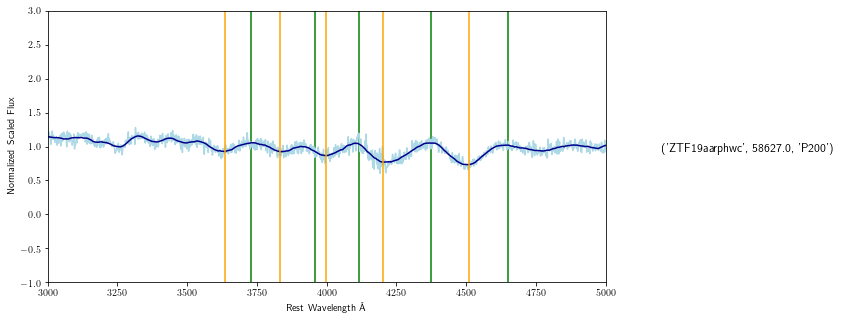

Eqivalent width for O1 is [252.27847132] Angstrom
Eqivalent width for O2 is [197.38454469] Angstrom
Eqivalent width for O3 is [193.88067703] Angstrom
Eqivalent width for O4 is [270.96576549] Angstrom
Eqivalent width for O5 is [246.43869189] Angstrom

Weighted Average Velocity
[9677.65532263]

Velocity error
[868.30784968 930.23622806 845.52072959 494.38719291 542.05939421]

Rest_minima error
[[10.78898552]
 [12.27859108]
 [11.59820514]
 [ 7.21141175]
 [ 8.40320348]]

 Rest equivalent width error
[47.42992687 57.13063179 54.85332595 48.8871277  55.30640346]

 ('ZTF19aarphwc', 58627.0, 'P200')
Rest_1: [3636.44022363] Angstrom, Velocity1 is : [7335.82097536] km/s
Rest_2: [3847.84023895] Angstrom, Velocity2 is : [8484.43703753] km/s
Rest_3: [3998.50654821] Angstrom, Velocity3 is : [8504.8820672] km/s
Rest_4: [4229.76181359] Angstrom, Velocity4 is : [10023.48186208] km/s
Rest_5: [4508.90327028] Angstrom, Velocity5 is : [9103.01482087] km/s


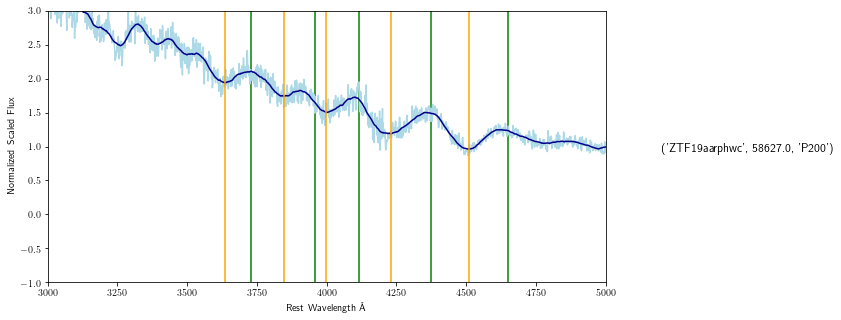

Eqivalent width for O1 is [251.11051543] Angstrom
Eqivalent width for O2 is [193.88067703] Angstrom
Eqivalent width for O3 is [197.38454469] Angstrom
Eqivalent width for O4 is [272.13372138] Angstrom
Eqivalent width for O5 is [246.43869189] Angstrom

Weighted Average Velocity
[9818.02036685]

Velocity error
[396.60682885 579.21385798 645.0051437  292.78174796 408.47676095]

Rest_minima error
[[4.92795883]
 [7.6452947 ]
 [8.84768606]
 [4.27068049]
 [6.33235652]]

 Rest equivalent width error
[15.1336519  31.68119932 43.09475615 21.95292737 53.44576789]


In [15]:
target_name = "ZTF19aarphwc"
spec = "ZTF19aarphwc_20190524_P200_v1.ascii"
date = "t-18"

row = 2

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spec, row, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

normalize_spectra_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width_new(target_name, spec, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF18acxgqxq

 ('ZTF18acxgqxq', 58490.0, 'P200')
Rest_1: [3641.12013243] Angstrom, Velocity1 is : [6959.17745009] km/s
Rest_2: [3846.68138105] Angstrom, Velocity2 is : [8572.23307188] km/s
Rest_3: [4010.16868989] Angstrom, Velocity3 is : [7654.70029955] km/s
Rest_4: [4220.53838878] Angstrom, Velocity4 is : [10655.80508264] km/s
Rest_5: [4523.47075516] Angstrom, Velocity5 is : [8163.17708625] km/s


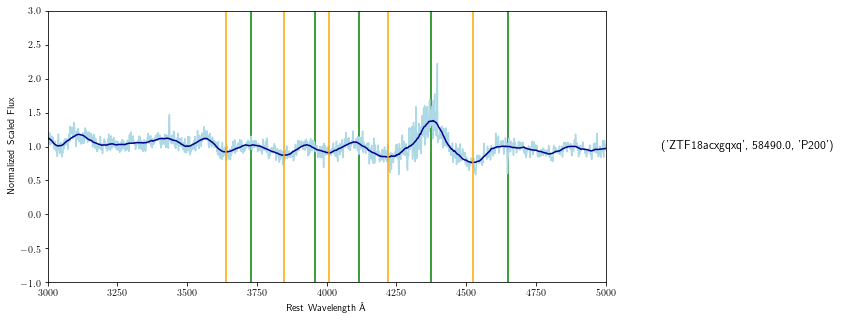

Eqivalent width for O1 is [170.69998423] Angstrom
Eqivalent width for O2 is [181.51899732] Angstrom
Eqivalent width for O3 is [199.5506858] Angstrom
Eqivalent width for O4 is [271.6774397] Angstrom
Eqivalent width for O5 is [239.22040044] Angstrom

Weighted Average Velocity
[8652.47883215]

Velocity error
[ 667.70829028  973.37130492 1370.89210828  748.61111863  393.80480614]

Rest_minima error
[[ 8.29647582]
 [12.84794965]
 [18.80484692]
 [10.91966599]
 [ 6.1049065 ]]

 Rest equivalent width error
[36.59590583 50.81930593 64.16815889 34.28162149 48.66682672]

 ('ZTF18acxgqxq', 58490.0, 'P200')
Rest_1: [3641.12013243] Angstrom, Velocity1 is : [6959.17745009] km/s
Rest_2: [3857.50039414] Angstrom, Velocity2 is : [7752.57568113] km/s
Rest_3: [4010.16868989] Angstrom, Velocity3 is : [7654.70029955] km/s
Rest_4: [4220.53838878] Angstrom, Velocity4 is : [10655.80508264] km/s
Rest_5: [4523.47075516] Angstrom, Velocity5 is : [8163.17708625] km/s


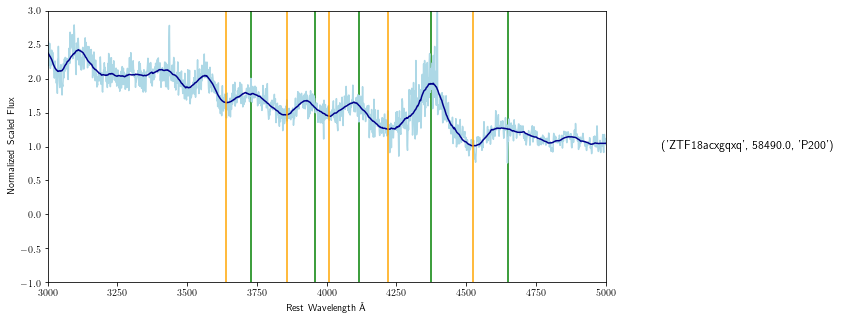

Eqivalent width for O1 is [170.69998423] Angstrom
Eqivalent width for O2 is [181.51899732] Angstrom
Eqivalent width for O3 is [175.50843449] Angstrom
Eqivalent width for O4 is [292.1133533] Angstrom
Eqivalent width for O5 is [242.82673814] Angstrom

Weighted Average Velocity
[8518.20366446]

Velocity error
[ 515.32372437  792.8188287  1430.97906082  439.20110906  379.6074719 ]

Rest_minima error
[[ 6.40305187]
 [10.46475927]
 [19.62907367]
 [ 6.40643626]
 [ 5.88481422]]

 Rest equivalent width error
[23.21609277 48.15810821 67.3865136  31.5995548  49.59783305]


In [16]:
target_name = "ZTF18acxgqxq"
spec = "ZTF18acxgqxq_20190107_P200_v2.ascii"
date = "t-6"

row = 9

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spec, row, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

normalize_spectra_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width_new(target_name, spec, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF18abshezu

 ('ZTF18abshezu', 58373.0, 'P200')
Rest_1: [3603.73376623] Angstrom, Velocity1 is : [9968.06787492] km/s
Rest_2: [3839.93506494] Angstrom, Velocity2 is : [9083.33956748] km/s
Rest_3: [3950.32467532] Angstrom, Velocity3 is : [12017.38868688] km/s
Rest_4: [4192.20779221] Angstrom, Velocity4 is : [12598.04393944] km/s
Rest_5: [4487.66233766] Angstrom, Velocity5 is : [10473.39757017] km/s


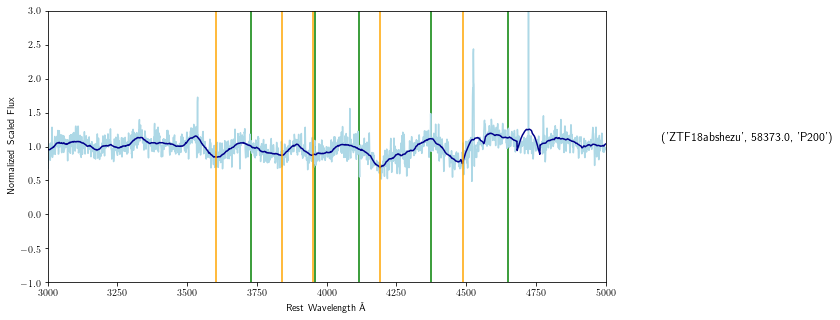

Eqivalent width for O1 is [174.51298701] Angstrom
Eqivalent width for O2 is [194.80519481] Angstrom
Eqivalent width for O3 is [158.27922078] Angstrom
Eqivalent width for O4 is [306.00649351] Angstrom
Eqivalent width for O5 is [237.01298701] Angstrom

Weighted Average Velocity
[11059.68878744]

Velocity error
[ 465.59618068 1039.78596474 1267.46080709  408.25296132  804.40935627]

Rest_minima error
[[ 5.78517222]
 [13.72458552]
 [17.38605563]
 [ 5.95500904]
 [12.47024879]]

 Rest equivalent width error
[40.62190811 39.28199541 59.74691384 28.11248843 56.16081684]

 ('ZTF18abshezu', 58373.0, 'P200')
Rest_1: [3603.73376623] Angstrom, Velocity1 is : [9968.06787492] km/s
Rest_2: [3839.93506494] Angstrom, Velocity2 is : [9083.33956748] km/s
Rest_3: [3960.87662338] Angstrom, Velocity3 is : [11248.1411429] km/s
Rest_4: [4192.20779221] Angstrom, Velocity4 is : [12598.04393944] km/s
Rest_5: [4487.66233766] Angstrom, Velocity5 is : [10473.39757017] km/s


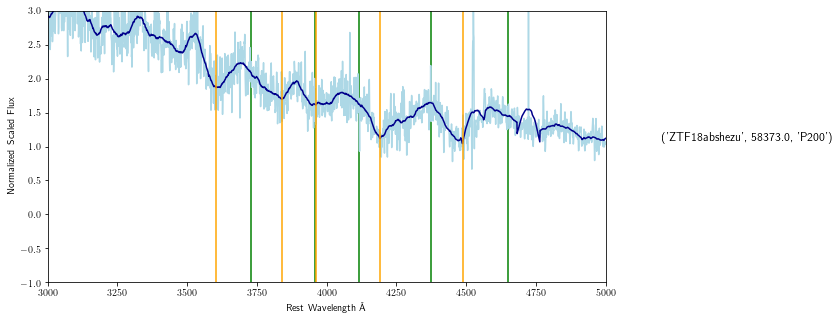

Eqivalent width for O1 is [174.51298701] Angstrom
Eqivalent width for O2 is [194.80519481] Angstrom
Eqivalent width for O3 is [158.27922078] Angstrom
Eqivalent width for O4 is [305.19480519] Angstrom
Eqivalent width for O5 is [237.82467532] Angstrom

Weighted Average Velocity
[10821.74722126]

Velocity error
[ 608.78063534  965.22384892 1636.51240812  619.63676059  941.53885526]

Rest_minima error
[[ 7.56428203]
 [12.74040785]
 [22.44842256]
 [ 9.03837292]
 [14.59608057]]

 Rest equivalent width error
[36.02708954 42.38913193 65.67618589 32.3311656  54.37964   ]


In [17]:
target_name = "ZTF18abshezu"
spec = "ZTF18abshezu_20180912_P200_v2.ascii"
date = "t-58"

row = 16

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spec, row, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

normalize_spectra_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width_new(target_name, spec, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF18abshezu

 ('ZTF18abshezu', 58374.0, 'P200')
Rest_1: [3604.11931818] Angstrom, Velocity1 is : [9937.03828625] km/s
Rest_2: [3813.31168831] Angstrom, Velocity2 is : [11100.34862772] km/s
Rest_3: [3950.71022727] Angstrom, Velocity3 is : [11989.28156508] km/s
Rest_4: [4190.84821429] Angstrom, Velocity4 is : [12691.25147437] km/s
Rest_5: [4465.64529221] Angstrom, Velocity5 is : [11893.85211563] km/s


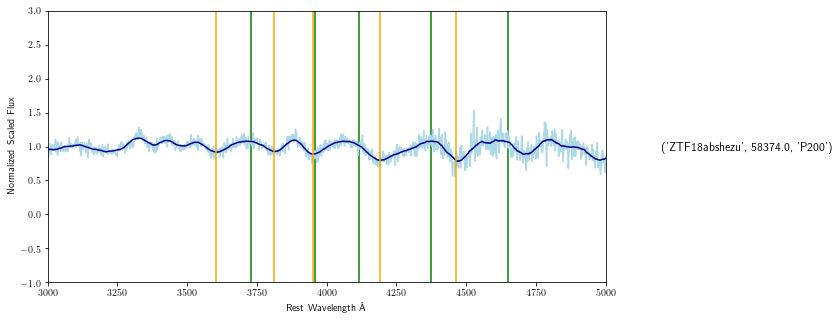

Eqivalent width for O1 is [158.44155844] Angstrom
Eqivalent width for O2 is [180.7224026] Angstrom
Eqivalent width for O3 is [179.48457792] Angstrom
Eqivalent width for O4 is [308.21834416] Angstrom
Eqivalent width for O5 is [262.41883117] Angstrom

Weighted Average Velocity
[11567.253017]

Velocity error
[688.14533764 779.98132695 315.91869787 741.2560524  608.02559883]

Rest_minima error
[[ 8.55041226]
 [10.29531153]
 [ 4.33353049]
 [10.81238083]
 [ 9.42583578]]

 Rest equivalent width error
[45.22984045 53.87822311 38.59891691 42.39648698 49.37113678]

 ('ZTF18abshezu', 58374.0, 'P200')
Rest_1: [3610.30844156] Angstrom, Velocity1 is : [9438.93173135] km/s
Rest_2: [3821.97646104] Angstrom, Velocity2 is : [10443.89827046] km/s
Rest_3: [3950.71022727] Angstrom, Velocity3 is : [11989.28156508] km/s
Rest_4: [4190.84821429] Angstrom, Velocity4 is : [12691.25147437] km/s
Rest_5: [4474.31006494] Angstrom, Velocity5 is : [11334.83452032] km/s


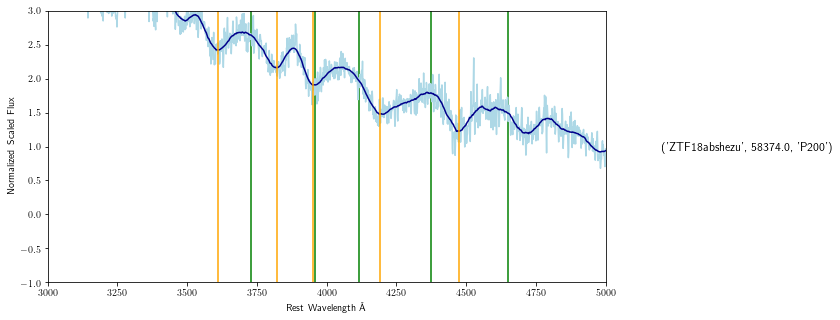

Eqivalent width for O1 is [167.10633117] Angstrom
Eqivalent width for O2 is [180.7224026] Angstrom
Eqivalent width for O3 is [175.7711039] Angstrom
Eqivalent width for O4 is [309.45616883] Angstrom
Eqivalent width for O5 is [266.13230519] Angstrom

Weighted Average Velocity
[11191.55088925]

Velocity error
[513.65658939 613.73934432 312.10006221 961.42894685 721.49861155]

Rest_minima error
[[ 6.38233722]
 [ 8.10101156]
 [ 4.28114938]
 [14.02394743]
 [11.18493603]]

 Rest equivalent width error
[21.23085264 54.50479872 11.78156601 48.63173322 54.21037917]


In [18]:
target_name = "ZTF18abshezu"
spec = "ZTF18abshezu_20180913_P200_v1.ascii"
date = "t-57"

row = 23

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spec, row, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

normalize_spectra_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width_new(target_name, spec, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF18abshezu

 ('ZTF18abshezu', 58397.0, 'P200')
Rest_1: [3622.56331169] Angstrom, Velocity1 is : [8452.64808992] km/s
Rest_2: [3837.49188312] Angstrom, Velocity2 is : [9268.43704526] km/s
Rest_3: [3980.72321429] Angstrom, Velocity3 is : [9801.30485843] km/s
Rest_4: [4210.94805195] Angstrom, Velocity4 is : [11313.28240723] km/s
Rest_5: [4493.4586039] Angstrom, Velocity5 is : [10099.44490993] km/s


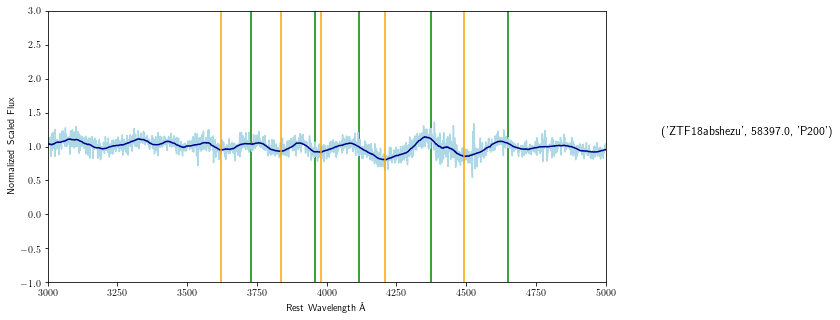

Eqivalent width for O1 is [144.99350649] Angstrom
Eqivalent width for O2 is [160.09090909] Angstrom
Eqivalent width for O3 is [174.0211039] Angstrom
Eqivalent width for O4 is [274.46915584] Angstrom
Eqivalent width for O5 is [264.23051948] Angstrom

Weighted Average Velocity
[10328.47675858]

Velocity error
[1729.18569029 1182.97452261 1149.42370773  714.26098464  806.18448905]

Rest_minima error
[[21.48565096]
 [15.61459335]
 [15.7669132 ]
 [10.41861547]
 [12.49776755]]

 Rest equivalent width error
[63.99921797 57.97644618 53.58712912 47.78326139 41.58448775]

 ('ZTF18abshezu', 58397.0, 'P200')
Rest_1: [3651.74107143] Angstrom, Velocity1 is : [6104.39414513] km/s
Rest_2: [3837.49188312] Angstrom, Velocity2 is : [9268.43704526] km/s
Rest_3: [3980.72321429] Angstrom, Velocity3 is : [9801.30485843] km/s
Rest_4: [4211.82873377] Angstrom, Velocity4 is : [11252.90618312] km/s
Rest_5: [4509.44480519] Angstrom, Velocity5 is : [9068.07708421] km/s


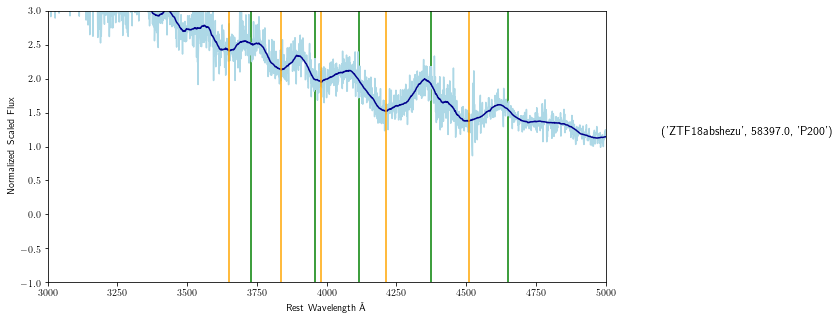

Eqivalent width for O1 is [242.11525974] Angstrom
Eqivalent width for O2 is [211.39529221] Angstrom
Eqivalent width for O3 is [170.49188312] Angstrom
Eqivalent width for O4 is [268.35470779] Angstrom
Eqivalent width for O5 is [273.87418831] Angstrom

Weighted Average Velocity
[8856.88232286]

Velocity error
[1686.57496522  925.01396208 1336.17164815  913.62926072 1125.25258829]

Rest_minima error
[[20.95619992]
 [12.20966012]
 [18.32857827]
 [13.32671412]
 [17.44407822]]

 Rest equivalent width error
[61.03174563 54.06445895 59.36962256 46.03921235 53.09451747]


In [19]:
target_name = "ZTF18abshezu"
spec = "ZTF18abshezu_20181006_P200_v2.ascii"
date = "t-35"

row = 30

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spec, row, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

normalize_spectra_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width_new(target_name, spec, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF18abshezu

 ('ZTF18abshezu', 58433.0, 'Keck1')
Rest_1: [3668.40706169] Angstrom, Velocity1 is : [4763.09934663] km/s
Rest_2: [3856.92410714] Angstrom, Velocity2 is : [7796.23566091] km/s
Rest_3: [4033.61769481] Angstrom, Velocity3 is : [5945.2444391] km/s
Rest_4: [4255.39050325] Angstrom, Velocity4 is : [8266.47555307] km/s
Rest_5: [4495.11801948] Angstrom, Velocity5 is : [9992.38583997] km/s


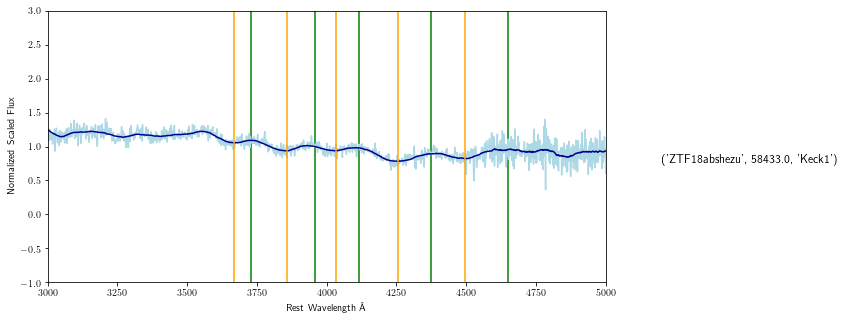

Eqivalent width for O1 is [189.71988636] Angstrom
Eqivalent width for O2 is [195.99423701] Angstrom
Eqivalent width for O3 is [155.43944805] Angstrom
Eqivalent width for O4 is [280.89334416] Angstrom
Eqivalent width for O5 is [212.06071429] Angstrom

Weighted Average Velocity
[7739.37100613]

Velocity error
[ 898.68162363 1177.83890624  985.44709619  775.3203936  1390.03704828]

Rest_minima error
[[11.16638878]
 [15.54680612]
 [13.51760776]
 [11.30926261]
 [21.548864  ]]

 Rest equivalent width error
[33.92711557 57.47730482 54.31313905 48.74208096 69.89907832]

 ('ZTF18abshezu', 58433.0, 'Keck1')
Rest_1: [3679.05373377] Angstrom, Velocity1 is : [3906.24501893] km/s
Rest_2: [3856.92410714] Angstrom, Velocity2 is : [7796.23566091] km/s
Rest_3: [4035.40438312] Angstrom, Velocity3 is : [5814.99307803] km/s
Rest_4: [4255.39050325] Angstrom, Velocity4 is : [8266.47555307] km/s
Rest_5: [4505.84431818] Angstrom, Velocity5 is : [9300.36656891] km/s


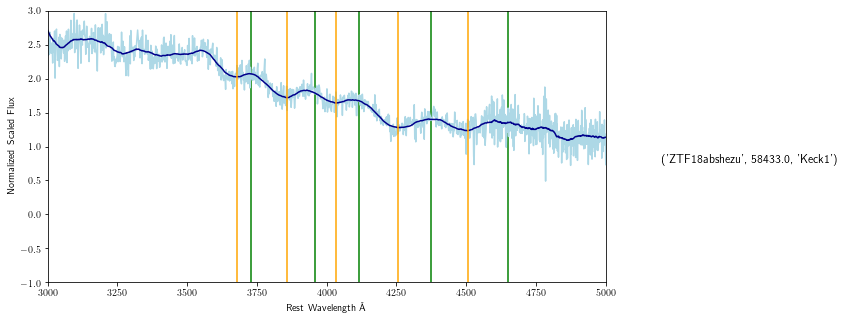

Eqivalent width for O1 is [148.84967532] Angstrom
Eqivalent width for O2 is [236.8512987] Angstrom
Eqivalent width for O3 is [139.34131494] Angstrom
Eqivalent width for O4 is [296.98279221] Angstrom
Eqivalent width for O5 is [215.6387987] Angstrom

Weighted Average Velocity
[7399.69009606]

Velocity error
[1031.45335257 1449.1038472  1179.51094663  956.9583207  1621.6207321 ]

Rest_minima error
[[12.81611734]
 [19.12734962]
 [16.17962687]
 [13.95873634]
 [25.13895918]]

 Rest equivalent width error
[34.93334591 60.34350754 49.56194004 47.60453483 72.09787835]


In [20]:
target_name = "ZTF18abshezu"
spec = "ZTF18abshezu_20181111_Keck1_v1.ascii"
date = "t+1"

row = 37

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spec, row, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

normalize_spectra_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500)
equivalent_width_new(target_name, spec, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors_new(target_name, spec, row, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF18abszecm

 ('ZTF18abszecm', 58374.0, 'P200')
Rest_2: [3679.24232937] Angstrom, Velocity2 is : [21257.55428635] km/s
Rest_3: [3846.8830446] Angstrom, Velocity3 is : [19558.38680316] km/s
Rest_4: [4045.29325819] Angstrom, Velocity4 is : [22669.95032925] km/s
Rest_5: [4280.83907326] Angstrom, Velocity5 is : [23816.83398307] km/s


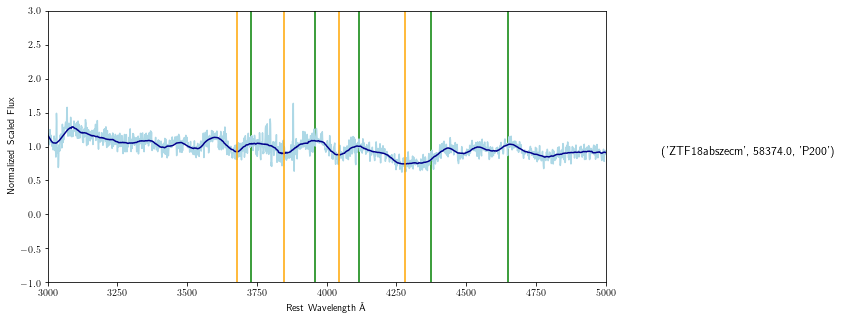

Eqivalent width for O2 is [137.93223405] Angstrom
Eqivalent width for O3 is [239.78988381] Angstrom
Eqivalent width for O4 is [159.15257775] Angstrom
Eqivalent width for O5 is [432.89501148] Angstrom

Weighted Average Velocity
[21938.59365111]

Velocity error
[ 709.69279591  697.92728205  474.78266194 1723.01263415]

Rest_minima error
[[ 9.36754275]
 [ 9.57363138]
 [ 6.92544895]
 [26.71077363]]

 Rest equivalent width error
[51.73533945 54.10647835 49.92225133 71.35824335]

 ('ZTF18abszecm', 58374.0, 'P200')
Rest_2: [3679.24232937] Angstrom, Velocity2 is : [21257.55428635] km/s
Rest_3: [3846.8830446] Angstrom, Velocity3 is : [19558.38680316] km/s
Rest_4: [4045.29325819] Angstrom, Velocity4 is : [22669.95032925] km/s
Rest_5: [4327.5238294] Angstrom, Velocity5 is : [20804.91423211] km/s


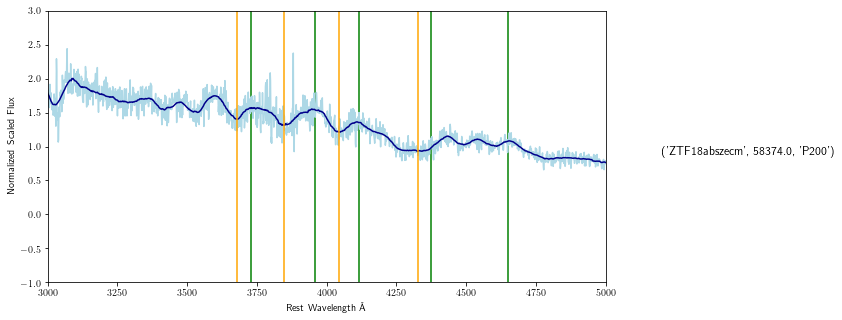

Eqivalent width for O2 is [137.93223405] Angstrom
Eqivalent width for O3 is [239.78988381] Angstrom
Eqivalent width for O4 is [125.20002783] Angstrom
Eqivalent width for O5 is [432.89501148] Angstrom

Weighted Average Velocity
[21343.45512196]

Velocity error
[ 692.18163643  590.13697527  477.27004974 1692.69263337]

Rest_minima error
[[ 9.13640536]
 [ 8.09504659]
 [ 6.9617314 ]
 [26.24074186]]

 Rest equivalent width error
[44.12878022 55.81137    38.16710327 68.48968107]


In [21]:
target_name = "ZTF18abszecm"
spec = "ZTF18abszecm_20180913_P200_v1.ascii"
date = "t-51"

row = 44

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 0, 3687, 3835, 4060, 4330)
equivalent_width(target_name, spec, row, 0, 0, 3600, 3780, 3780, 3950, 3950, 4120, 4120, 4550)
errors(target_name, spec, row, 0, 3687, 3835, 4060, 4330, 0, 0, 3600, 3780, 3780, 3965, 3965, 4100, 4100, 4400)


normalize_spectra_new(target_name, spec, row, 0, 3687, 3835, 4060, 4330)
equivalent_width_new(target_name, spec, 0, 0, 3600, 3780, 3780, 3950, 3950, 4120, 4120, 4550)
errors_new(target_name, spec, row, 0, 3687, 3835, 4060, 4330, 0, 0, 3600, 3780, 3780, 3965, 3965, 4100, 4100, 4400)

ZTF18abmasep

 ('ZTF18abmasep', 58351.0, 'P200')
Rest_1: [3631.64108619] Angstrom, Velocity1 is : [7722.06013645] km/s
Rest_2: [3825.0840069] Angstrom, Velocity2 is : [10208.46802245] km/s
Rest_3: [3974.02597403] Angstrom, Velocity3 is : [10289.54035731] km/s
Rest_4: [4199.25529016] Angstrom, Velocity4 is : [12114.89405793] km/s
Rest_5: [4500.77195532] Angstrom, Velocity5 is : [9627.61578597] km/s


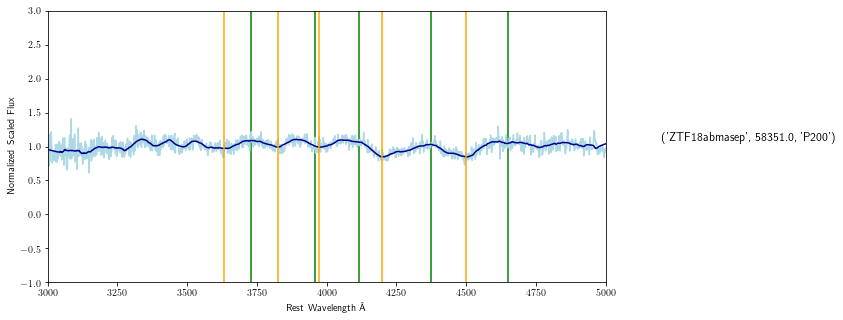

Eqivalent width for O1 is [192.53473799] Angstrom
Eqivalent width for O2 is [147.12560167] Angstrom
Eqivalent width for O3 is [195.25928617] Angstrom
Eqivalent width for O4 is [318.77213695] Angstrom
Eqivalent width for O5 is [230.6784125] Angstrom

Weighted Average Velocity
[10207.95154535]

Velocity error
[1931.01761378 1140.50236283 1493.45579423  563.4908651   603.29606875]

Rest_minima error
[[23.99347316]
 [15.0539849 ]
 [20.4860816 ]
 [ 8.21939707]
 [ 9.35251687]]

 Rest equivalent width error
[64.52676002 49.61053103 63.91141556 47.08643618 37.85489002]

 ('ZTF18abmasep', 58351.0, 'P200')
Rest_1: [3647.08019253] Angstrom, Velocity1 is : [6479.50612583] km/s
Rest_2: [3825.0840069] Angstrom, Velocity2 is : [10208.46802245] km/s
Rest_3: [3974.02597403] Angstrom, Velocity3 is : [10289.54035731] km/s
Rest_4: [4200.16347289] Angstrom, Velocity4 is : [12052.63247526] km/s
Rest_5: [4500.77195532] Angstrom, Velocity5 is : [9627.61578597] km/s


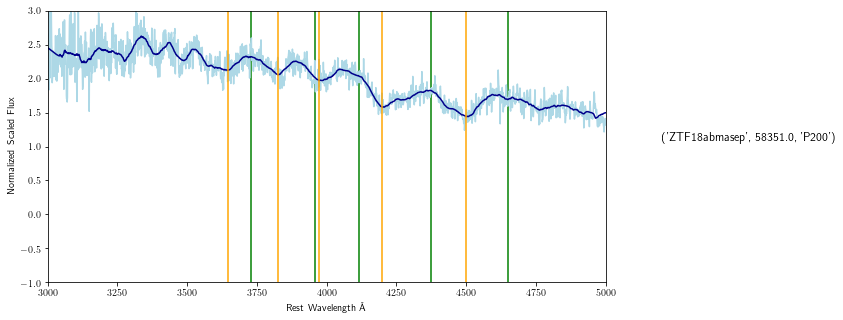

Eqivalent width for O1 is [193.44292072] Angstrom
Eqivalent width for O2 is [146.21741894] Angstrom
Eqivalent width for O3 is [190.71837254] Angstrom
Eqivalent width for O4 is [324.22123331] Angstrom
Eqivalent width for O5 is [219.78021978] Angstrom

Weighted Average Velocity
[10126.85598597]

Velocity error
[ 516.92609443  446.94457962 1201.22475436  306.43058033  377.04471848]

Rest_minima error
[[ 6.4229618 ]
 [ 5.89941518]
 [16.47748024]
 [ 4.46977009]
 [ 5.84508548]]

 Rest equivalent width error
[41.08556256 22.64898077 52.31937099 22.85696948 32.29849036]


In [22]:
target_name = "ZTF18abmasep"
spec = "ZTF18abmasep_20180821_P200_v1.ascii"
date = "t-7"

row = 51

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3600, 3835, 3980, 4220, 4500)
equivalent_width(target_name, spec, row, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)
errors(target_name, spec, row, 3600, 3835, 3980, 4220, 4500, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)

normalize_spectra_new(target_name, spec, row, 3600, 3835, 3980, 4220, 4500)
equivalent_width_new(target_name, spec, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)
errors_new(target_name, spec, row, 3600, 3835, 3980, 4220, 4500, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)


ZTF18aazgrfl

 ('ZTF18aazgrfl', 58313.0, 'WHT')
Rest_3: [3939.05306834] Angstrom, Velocity3 is : [12839.10008527] km/s
Rest_4: [4192.68563459] Angstrom, Velocity4 is : [12565.28486791] km/s
Rest_5: [4480.90439331] Angstrom, Velocity5 is : [10909.39398029] km/s


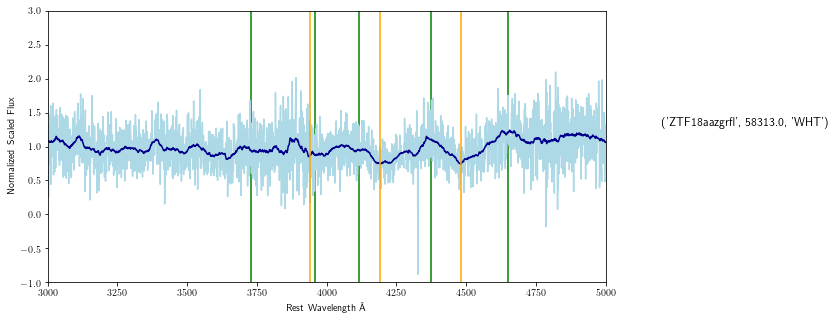

Eqivalent width for O4 is [304.87140865] Angstrom
Eqivalent width for O5 is [297.82615063] Angstrom

Weighted Average Velocity
[11189.89939737]

Velocity error
[1132.49612346  229.82754894]

Rest_minima error
[[16.5192302 ]
 [ 3.56287093]]

 Rest equivalent width error
[52.87164111 22.92747431]

 ('ZTF18aazgrfl', 58313.0, 'WHT')
Rest_3: [3994.1348675] Angstrom, Velocity3 is : [8823.58195383] km/s
Rest_4: [4222.14797768] Angstrom, Velocity4 is : [10545.45773727] km/s
Rest_5: [4480.90439331] Angstrom, Velocity5 is : [10909.39398029] km/s


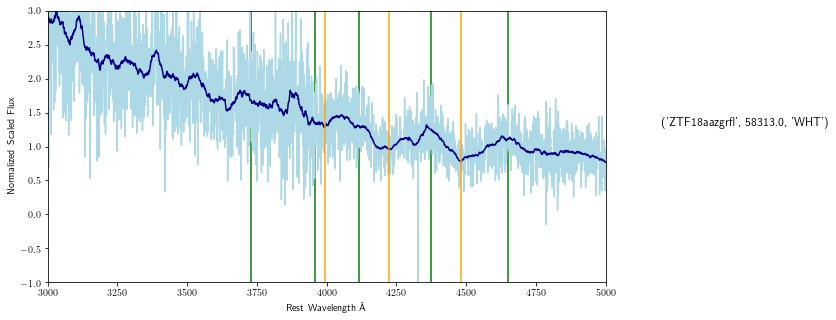

Eqivalent width for O4 is [304.87140865] Angstrom
Eqivalent width for O5 is [297.18563459] Angstrom

Weighted Average Velocity
[10624.58221169]

Velocity error
[1959.2680306  1799.49425827]

Rest_minima error
[[28.57899375]
 [27.89641981]]

 Rest equivalent width error
[55.49433311 55.66770811]


In [29]:
target_name = "ZTF18aazgrfl"
spec = "ZTF18aazgrfl_20180714_WHT_v1.ascii"
date = "t-9"

row = 58

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 0, 0, 3980, 4220, 4500)
equivalent_width(target_name, spec, row, 0, 0, 0, 0, 0, 0, 4080, 4360, 4360, 4640)
errors(target_name, spec, row, 0, 0, 0, 4220, 4500, 0, 0, 0, 0, 0, 0, 4080, 4360, 4360, 4640)

normalize_spectra_new(target_name, spec, row, 0, 0, 3980, 4220, 4500)
equivalent_width_new(target_name, spec, 0, 0, 0, 0, 0, 0, 4080, 4360, 4360, 4640)
errors_new(target_name, spec, row, 0, 0, 0, 4220, 4500, 0, 0, 0, 0, 0, 0, 4080, 4360, 4360, 4640)


ZTF18abjwagv

 ('ZTF18abjwagv', 58343.0, 'P200')
Rest_1: [3611.82156134] Angstrom, Velocity1 is : [9317.15440768] km/s
Rest_4: [4199.14498141] Angstrom, Velocity4 is : [12122.45640994] km/s
Rest_5: [4470.13011152] Angstrom, Velocity5 is : [11604.50893392] km/s


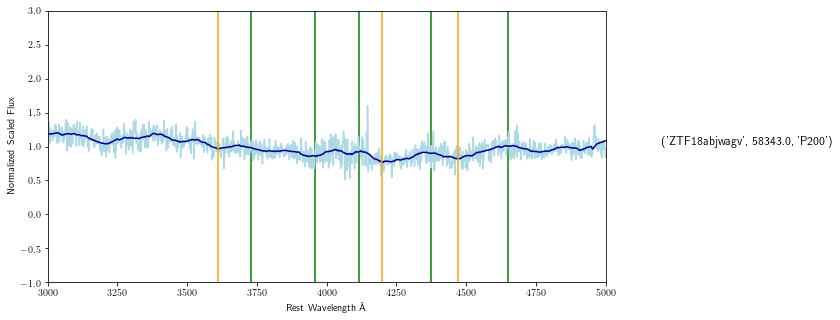

Eqivalent width for O1 is [168.94052045] Angstrom
Eqivalent width for O4 is [329.94423792] Angstrom
Eqivalent width for O5 is [281.18959108] Angstrom

Weighted Average Velocity
[10344.80458932]

Velocity error
[ 899.35932683  964.73413823 1357.22958786]

Rest_minima error
[[11.17480944]
 [14.07215882]
 [21.04027072]]

 Rest equivalent width error
[49.5076325  49.20082803 62.52453805]

 ('ZTF18abjwagv', 58343.0, 'P200')
Rest_1: [3611.82156134] Angstrom, Velocity1 is : [9317.15440768] km/s
Rest_4: [4229.75836431] Angstrom, Velocity4 is : [10023.71833132] km/s
Rest_5: [4475.79925651] Angstrom, Velocity5 is : [11238.7576448] km/s


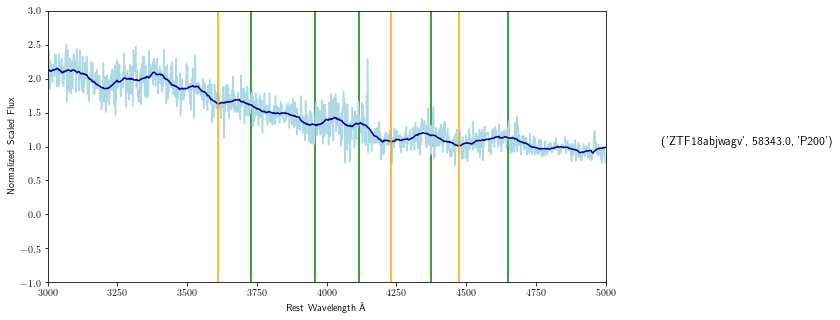

Eqivalent width for O1 is [168.94052045] Angstrom
Eqivalent width for O4 is [329.94423792] Angstrom
Eqivalent width for O5 is [281.18959108] Angstrom

Weighted Average Velocity
[9762.55588491]

Velocity error
[ 730.77637915 1422.77539767 1492.61079365]

Rest_minima error
[[ 9.08011574]
 [20.75340819]
 [23.13899981]]

 Rest equivalent width error
[41.55133549 52.91057729 60.7339453 ]


In [30]:
target_name = "ZTF18abjwagv"
spec = "ZTF18abjwagv_20180813_P200_v1.ascii"
date = "t-13"

row = 65

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3615, 0, 0, 4220, 4500)
equivalent_width(target_name, spec, row, 3530, 3730, 0, 0, 0, 0, 4080, 4360, 4360, 4640)
errors(target_name, spec, row, 3615, 0, 0, 4220, 4500, 3530, 3730, 0, 0, 0, 0, 4080, 4360, 4360, 4640)

normalize_spectra_new(target_name, spec, row, 3615, 0, 0, 4220, 4500)
equivalent_width_new(target_name, spec, 3530, 3730, 0, 0, 0, 0, 4080, 4360, 4360, 4640)
errors_new(target_name, spec, row, 3615, 0, 0, 4220, 4500, 3530, 3730, 0, 0, 0, 0, 4080, 4360, 4360, 4640)

In [ ]:
target_name = "ZTF18abmasep"
spec = "ZTF18abmasep_20180821_P200_v1.ascii"
date = "t-7"

row = 51

worksheet1.write(row, 0, target_name)
worksheet2.write(row, 0, target_name)

worksheet1.write(row, 1, spec)
worksheet2.write(row, 1, spec)

worksheet1.write(row, 2, date)
worksheet2.write(row, 2, date)

normalize_spectra(target_name, spec, row, 3600, 3835, 3980, 4220, 4500)
equivalent_width(target_name, spec, row, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)
errors(target_name, spec, row, 3600, 3835, 3980, 4220, 4500, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)

normalize_spectra_new(target_name, spec, row, 3600, 3835, 3980, 4220, 4500)
equivalent_width_new(target_name, spec, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)
errors_new(target_name, spec, row, 3600, 3835, 3980, 4220, 4500, 3530, 3730, 3730, 3900, 3900, 4080, 4080, 4360, 4360, 4600)



In [23]:
workbook.close()

In [40]:
new_date = "2019-01-13"   
normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

Julian_date = normal_date.mjd #convert to MJD
print (Julian_date)

58496.0


In [41]:
new_date = "2019-07-02"   
normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

Julian_date = normal_date.mjd #convert to MJD
print (Julian_date)

58666.0


In [423]:
user = "AishwaryaD"   #Marshal Username
passw = "bBrA@7592"   #Marshal Password
program_index = "10"  #program id for the program which contains the candidates you are interested in, 
                      #same program has different id for every different user 

# Where will the data be stored from this python run? 
date_directory= "new"#input
mkdir_date_dir = os.system("mkdir data/%s"%date_directory) # make a new directory where we will store the datapath


for target in targets:
    print (target)
    
    spectra = fetch_ZTF_spectrum(target, user, passw, program_idx=10) # Get the URLs of all available spectra for a source
    print (spectra)
    
    for spec in spectra:
        spec_download = download_spectra(spec, target, date_directory) # download all spectra to data path
        print (spec_download)
       
    out_files_path = glob.glob("data/%s/%s/spectra/*.ascii"%(date_directory, target))

ZTF18abszecm


KeyboardInterrupt: 

In [35]:
def normalize_spectra(target_name, spec, row, O1, O2, O3, O4, O5, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):
    
    
    """Returns a plot of the spectrum with absorbtion features marked for  arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    target_name (required): Name of the target from the list you are interested in (str)
    spec (required): Name of the particular specrtum for which you need the velocity and equivalent width (str)
    row (required): numer of the row where you want to start writing the output on the excel sheet. add '7' to the previous row number for every new candidate
    
    O1 (required): estimate wavelenth in rest frame of first feature(int)
    O2 (required): estimate wavelenth in rest frame of second feature(int)
    O3 (required): estimate wavelenth in rest frame of third feature(int)
    O4 (required): estimate wavelenth in rest frame of fourth feature(int)
    O5 (required): estimate wavelenth in rest frame of fifth feature(int)
    
    R1 (Optional, Deault value = 3727.59): Theoretical Rest wavelenth  of first feature(int)
    R2 (Optional, Deault value = 3959.83): Theoretical Rest wavelenth  of second feature(int)
    R3 (Optional, Deault value = 4115.17): Theoretical Rest wavelenth of third feature(int)
    R4 (Optional, Deault value = 4375.97): Theoretical Rest wavelenth of fourth feature(int)
    R5 (Optional, Deault value = 4650.71): Theoretical Rest wavelenth of fifth feature(int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):
                    
                    #print(d)

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string   

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name   

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18" 

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting


            flux = np.array([])
            wavelength = np.array([])

            fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))

            ax.set_xlim(3000,5000)
            ax.set_ylim(-1,3)
            ax.set_xlabel('Rest Wavelength Å')
            ax.set_ylabel('Normalized Scaled Flux')

            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

                print("\n", text[count])

                y_temp = k[1]   # Scaling flux values and saving in a temporary variable
                text_pos_y = np.median(y_temp)    # defining the location on y-axis
                ax.text(5200, (text_pos_y), text[count], size=12)
                
                plt.axvline(R1, color = 'green')
                plt.axvline(R2, color = 'green')
                plt.axvline(R3, color = 'green')
                plt.axvline(R4, color = 'green')
                plt.axvline(R5, color = 'green')

                variable = text[count][0]    # Only select the name of sourcec by indexing

                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                spectrum = Spectrum1D(flux = k[1]* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (k[0]/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((k[0]/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis
                


                #O1 = np.where ((wavelength > 3605*u.Angstrom) & (wavelength < 3655*u.Angstrom))
                O1 = np.where ((wavelength > (O1 - 50)*u.Angstrom) & (wavelength < (O1 + 50)*u.Angstrom))

                O1_flux = min(yhat[O1])
                O1_index = np.where(yhat == O1_flux)
                O1_min = wavelength[O1_index]
                O1_min2 = k[0][O1_index]
                #print ("Rest_1: %s"%O1_min)
                #print ("Observed_1: %s"%O1_min2)

                velocity1 = (abs(O1_min - (3727.59*u.Angstrom))/(3727.59*u.Angstrom))*(3*pow(10,5))
                print ("Rest_1: %s,"%O1_min, "Velocity1 is : %s km/s"%velocity1)


                #O2 = np.where ((wavelength >  3820*u.Angstrom) & (wavelength < 3870*u.Angstrom))
                O2 = np.where ((wavelength >  (O2 - 50)*u.Angstrom) & (wavelength < (O2 + 50)*u.Angstrom))
                
                O2_flux = min(yhat[O2])
                O2_index = np.where(yhat == O2_flux)
                O2_min = wavelength[O2_index]
                O2_min2 = k[0][O2_index]
                #print ("Rest_2: %s"%O2_min)
                #print ("Observed_2: %s"%O2_min2)

                velocity2 = (abs(O2_min - (3959.83*u.Angstrom))/(3959.83*u.Angstrom))*(3*pow(10,5))
                print ("Rest_2: %s,"%O2_min, "Velocity2 is : %s km/s"%velocity2)

                
                #O3 = np.where ((wavelength >  3970*u.Angstrom) & (wavelength < 4120*u.Angstrom))
                O3 = np.where ((wavelength >  (O3 - 50)*u.Angstrom) & (wavelength < (O3 + 50)*u.Angstrom))
                
                O3_flux = min(yhat[O3])
                O3_index = np.where(yhat == O3_flux)
                O3_min = wavelength[O3_index]
                O3_min2 = k[0][O3_index]
                #print ("Rest_3: %s"%O3_min)
                #print ("Observed_3: %s"%O3_min2) 

                velocity3 = (abs(O3_min - (4115.17*u.Angstrom))/(4115.17*u.Angstrom))*(3*pow(10,5))
                print ("Rest_3: %s,"%O3_min, "Velocity3 is : %s km/s"%velocity3)

                
                #O4 = np.where ((wavelength >  4205*u.Angstrom) & (wavelength < 4255*u.Angstrom))
                O4 = np.where ((wavelength >  (O4 - 50)*u.Angstrom) & (wavelength < (O4 + 50)*u.Angstrom))
                
                O4_flux = min(yhat[O4])
                O4_index = np.where(yhat == O4_flux)
                O4_min = wavelength[O4_index]
                O4_min2 = k[0][O4_index]
                #print ("Rest_4: %s"%O4_min)
                #print ("Observed_4: %s"%O4_min2) 

                velocity4 = (abs(O4_min - (4375.97*u.Angstrom))/(4375.97*u.Angstrom))*(3*pow(10,5))
                print ("Rest_4: %s,"%O4_min, "Velocity4 is : %s km/s"%velocity4)

                
                #O5 = np.where ((wavelength >  4490*u.Angstrom) & (wavelength < 4540*u.Angstrom))
                O5 = np.where ((wavelength >  (O5 - 50)*u.Angstrom) & (wavelength < (O5 + 50)*u.Angstrom))
                
                O5_flux = min(yhat[O5])
                O5_index = np.where(yhat == O5_flux)
                O5_min = wavelength[O5_index]
                O5_min2 = k[0][O5_index]
                #print ("Rest_4: %s"%O5_min)
                #print ("Observed_4: %s"%O5_min2) 


                velocity5 = (abs(O5_min - (4650*u.Angstrom))/(4650*u.Angstrom))*(3*pow(10,5))
                print ("Rest_5: %s,"%O5_min, "Velocity is : %s km/s"%velocity5)
                
                #velocities = np.array([velocity1, velocity2, velocity3, velocity4, velocity5])
                #minimums = np.array([O1_min, O2_min, O3_min, O4_min, O5_min])
                
                velocities = np.array([velocity2, velocity3, velocity4, velocity5])
                minimums = np.array([O2_min, O3_min, O4_min, O5_min])
                
                #average_velocity = (velocity1+velocity2+velocity3+velocity4+velocity5)/5
                #print("Average velocity is %s" %average_velocity)
                
                
                plt.plot(spec_normalized.spectral_axis, spec_normalized.flux, color ='lightblue')
                ax.plot(k[0]/z, yhat, color='darkblue')    #Plotting the x in rest wavelength and y in smoothed spectra + const
                 
                for i in range (len(velocities)):
                    
                    row += 1
                    
                    worksheet1.write(row, 0, 'Feature_%s' %(i+1))
                    worksheet2.write(row, 0, 'Feature_%s' %(i+1))
                    
                    worksheet1.write(row, 1, velocities[i])
                    worksheet2.write(row, 1, velocities[i])
                    
                    worksheet1.write(row, 5, minimums[i])
                    worksheet2.write(row, 7, minimums[i])
                    
                
                Oxygen1 = O1_min/u.Angstrom
                Oxygen2 = O2_min/u.Angstrom
                Oxygen3 = O3_min/u.Angstrom
                Oxygen4 = O4_min/u.Angstrom
                Oxygen5 = O5_min/u.Angstrom
                
                plt.axvline(Oxygen1, color = 'orange')
                plt.axvline(Oxygen2, color = 'orange')
                plt.axvline(Oxygen3, color = 'orange')
                plt.axvline(Oxygen4, color = 'orange')
                plt.axvline(Oxygen5, color = 'orange')    
                    
                inc += 1
                count = count+1  #to go through the Text array and print appropriate text besides every spectra

                bash1 = subprocess.run("mkdir plots", shell=True) 
                plt.savefig("plots/%s_normalized"%spec, format = 'pdf', bbox_inches = 'tight')
                plt.show()


In [36]:
def equivalent_width(target_name, spec, row, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max):
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []
    
    vel = []
    mini = []

    #target_name = "ZTF19aarphwc"
    #spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d ==  "data/new/%s/spectra/%s"%(target_name,spec):
                    
                    #print(d)

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name
                    #print (date)     

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
                    #print (new_date)  

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
                    #print (label)    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting

            #print (instrument)

            flux = np.array([])
            wavelength = np.array([])

            const = 0   #increment
            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

    
                #print (text[count])
                variable = text[count][0]    # Only select the name of sourcec by indexing
              
                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                spectrum = Spectrum1D(flux = k[1]* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (k[0]/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((k[0]/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis
                

                L1min = np.where ((wavelength > (O1_min - 50)*u.Angstrom) & (wavelength < (O1_min + 50)*u.Angstrom))
                L1min_flux = max(yhat[L1min])
                L1min_index = np.where(yhat == L1min_flux)
                L1min_rest = wavelength[L1min_index]
                L1min_observed = k[0][L1min_index]
                #print ("\n\n Rest_L1min: %s"%L1min_rest)
                #print ("Observed_L1min: %s"%L1min_observed)


                L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                L1max_flux = max(yhat[L1max])
                L1max_index = np.where(yhat == L1max_flux)
                L1max_rest = wavelength[L1max_index]
                L1max_observed = k[0][L1max_index]
                #print (" Rest_L1max: %s"%L1max_rest) 
                #print ("Observed_L1max: %s"%L1max_observed)

                pEW1_rest = L1max_rest - L1min_rest
                pEW1_observed = L1max_observed - L1min_observed



                print ("Eqivalent width for O1 is %s" %pEW1_rest)
                #print ("Eqivalent width for O1 from observed is %s" %pEW1_observed)


                L2min = np.where ((wavelength >  (O2_min - 50)*u.Angstrom) & (wavelength < (O2_min + 50)*u.Angstrom))
                L2min_flux = max(yhat[L2min])
                L2min_index = np.where(yhat == L2min_flux)
                L2min_rest = wavelength[L2min_index]
                L2min_observed = k[0][L2min_index]
                #print ("\n\n Rest_L2min: %s"%L2min_rest)
                #print ( "Observed_L2min: %s"%L2min_observed)


                L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                L2max_flux = max(yhat[L2max])
                L2max_index = np.where(yhat == L2max_flux)
                L2max_rest = wavelength[L2max_index]
                L2max_observed = k[0][L2max_index]
                #print (" Rest_L2max: %s"%L2max_rest) 
                #print ( "Observed_L2max: %s"%L2max_observed)

                pEW2_rest = L2max_rest - L2min_rest
                pEW2_observed = L2max_observed - L2min_observed



                print ("Eqivalent width for O2 is %s" %pEW2_rest) 
                #print ( "Eqivalent width for O2 from observed is %s" %pEW2_observed)

                L3min = np.where ((wavelength >  (O3_min - 50)*u.Angstrom) & (wavelength < (O3_min + 50)*u.Angstrom))
                L3min_flux = max(yhat[L3min])
                L3min_index = np.where(yhat == L3min_flux)
                L3min_rest = wavelength[L3min_index]
                L3min_observed = k[0][L3min_index]
                #print ("\n\n Rest_L3min: %s"%L3min_rest)
                #print ( "Observed_L3min: %s"%L3min_observed)

                L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                L3max_flux = max(yhat[L3max])
                L3max_index = np.where(yhat == L3max_flux)
                L3max_rest = wavelength[L3max_index]
                L3max_observed = k[0][L3max_index]
                #print (" Rest_L3max: %s"%L3max_rest)
                #print ( "Observed_L3max: %s"%L3max_observed)

                pEW3_rest = L3max_rest - L3min_rest
                pEW3_observed = L3max_observed - L3min_observed

                print ("Eqivalent width for O3 is %s" %pEW3_rest)
                #print ("Eqivalent width for O3 from observed is %s" %pEW3_observed)

                L4min = np.where ((wavelength >  (O4_min - 50)*u.Angstrom) & (wavelength < (O4_min + 50)*u.Angstrom))
                L4min_flux = max(yhat[L4min])
                L4min_index = np.where(yhat == L4min_flux)
                L4min_rest = wavelength[L4min_index]
                L4min_observed = k[0][L4min_index]
                #print ("\n\n Rest_L4min: %s"%L4min_rest)
                #print ("Observed_L4min: %s"%L4min_observed)

                L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                L4max_flux = max(yhat[L4max])
                L4max_index = np.where(yhat == L4max_flux)
                L4max_rest = wavelength[L4max_index]
                L4max_observed = k[0][L4max_index]
                #print (" Rest_L4max: %s"%L4max_rest)
                #print ("Observed_L4max: %s"%L4max_observed)

                pEW4_rest = L4max_rest - L4min_rest
                pEW4_observed = L4max_observed - L4min_observed

                print ("Eqivalent width for O4 is %s" %pEW4_rest)
                #print ("Eqivalent width for O4 from observed is %s" %pEW4_observed)


                L5min = np.where ((wavelength >  (O5_min - 50)*u.Angstrom) & (wavelength < (O5_min + 50)*u.Angstrom))
                L5min_flux = max(yhat[L5min])
                L5min_index = np.where(yhat == L5min_flux)
                L5min_rest = wavelength[L5min_index]
                L5min_observed = k[0][L5min_index]
                #print ("\n\n Rest_L5min: %s"%L5min_rest)
                #print ("Observed_L5min: %s"%L5min_observed)

                L5max = np.where ((wavelength > (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                L5max_flux = max(yhat[L5max])
                L5max_index = np.where(yhat == L5max_flux)
                L5max_rest = wavelength[L5max_index]
                L5max_observed = k[0][L5max_index]
                #print (" Rest_L5max: %s"%L5max_rest)
                #print ("Observed_L5max: %s"%L5max_observed)

                pEW5_rest = L5max_rest - L5min_rest
                pEW5_observed = L5max_observed - L5min_observed

                print ("Eqivalent width for O5 is %s" %pEW5_rest)
                #print ("Eqivalent width for O5 from observed is %s" %pEW5_observed)
                
                equivalent_width = np.array([pEW1_rest, pEW2_rest, pEW3_rest, pEW4_rest, pEW5_rest])
                left_limit = np.array([L1min_rest, L2min_rest, L3min_rest, L4min_rest, L5min_rest])
                right_limit = np.array([L1max_rest, L2max_rest, L3max_rest, L4max_rest, L5max_rest])
                
                for i in range (len(left_limit)):
                    
                    row += 1
                    
                    worksheet1.write(row, 7, equivalent_width[i])
                    worksheet2.write(row, 9, equivalent_width[i])
                    

                    worksheet2.write(row, 11, left_limit[i])
                    worksheet2.write(row, 13, right_limit[i])
                    

In [11]:
def normalize_spectra_new(target_name, spec, row, O1, O2, O3, O4, O5, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):
    
    
    """Returns a plot of the spectrum with absorbtion features marked for  arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    target_name (required): Name of the target from the list you are interested in (str)
    spectrum (required): Name of the particular specrtum for which you need the velocity and equivalent width (str)
    
    O1 (required): estimate wavelenth in rest frame of first feature(int)
    O2 (required): estimate wavelenth in rest frame of second feature(int)
    O3 (required): estimate wavelenth in rest frame of third feature(int)
    O4 (required): estimate wavelenth in rest frame of fourth feature(int)
    O5 (required): estimate wavelenth in rest frame of fifth feature(int)
    
    R1 (Optional, Deault value = 3727.59): Theoretical Rest wavelenth  of first feature(int)
    R2 (Optional, Deault value = 3959.83): Theoretical Rest wavelenth  of second feature(int)
    R3 (Optional, Deault value = 4115.17): Theoretical Rest wavelenth of third feature(int)
    R4 (Optional, Deault value = 4375.97): Theoretical Rest wavelenth of fourth feature(int)
    R5 (Optional, Deault value = 4650.71): Theoretical Rest wavelenth of fifth feature(int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string   

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name   

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18" 

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting


            flux = np.array([])
            wavelength = np.array([])

            fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))

            ax.set_xlim(3000,5000)
            ax.set_ylim(-1,3)
            ax.set_xlabel('Rest Wavelength Å')
            ax.set_ylabel('Normalized Scaled Flux')

            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

                print("\n", text[count])

                y_temp = k[1]   # Scaling flux values and saving in a temporary variable
                text_pos_y = np.median(y_temp)    # defining the location on y-axis
                ax.text(5200, (text_pos_y), text[count], size=12)
                
                plt.axvline(R1, color = 'green')
                plt.axvline(R2, color = 'green')
                plt.axvline(R3, color = 'green')
                plt.axvline(R4, color = 'green')
                plt.axvline(R5, color = 'green')

                variable = text[count][0]    # Only select the name of sourcec by indexing

                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)


                flux = (k[1])*u.Unit('W m-2 angstrom-1 sr-1')
                wavelength = (k[0]/z)*u.Angstrom
                
                yhat = scipy.signal.savgol_filter(flux, 51, 3)


                O1 = np.where ((wavelength > (O1 - 50)*u.Angstrom) & (wavelength < (O1 + 50)*u.Angstrom))
                
                O1_flux = min(yhat[O1])
                O1_index = np.where(yhat == O1_flux)
                O1_min = wavelength[O1_index]
                O1_min2 = k[0][O1_index]
                #print ("Rest_1: %s"%O1_min)
                #print ("Observed_1: %s"%O1_min2)

                velocity1 = (abs(O1_min - (3727.59*u.Angstrom))/(3727.59*u.Angstrom))*(3*pow(10,5))
                print ("Rest_1: %s,"%O1_min, "Velocity1 is : %s km/s"%velocity1)
                
                
                O2 = np.where ((wavelength >  (O2 - 50)*u.Angstrom) & (wavelength < (O2 + 50)*u.Angstrom))
                
                O2_flux = min(yhat[O2])
                O2_index = np.where(yhat == O2_flux)
                O2_min = wavelength[O2_index]
                O2_min2 = k[0][O2_index]
                #print ("Rest_2: %s"%O2_min)
                #print ("Observed_2: %s"%O2_min2)

                velocity2 = (abs(O2_min - (3959.83*u.Angstrom))/(3959.83*u.Angstrom))*(3*pow(10,5))
                print ("Rest_2: %s,"%O2_min, "Velocity2 is : %s km/s"%velocity2)

                
                O3 = np.where ((wavelength >  (O3 - 50)*u.Angstrom) & (wavelength < (O3 + 50)*u.Angstrom))
                
                O3_flux = min(yhat[O3])
                O3_index = np.where(yhat == O3_flux)
                O3_min = wavelength[O3_index]
                O3_min2 = k[0][O3_index]
                #print ("Rest_3: %s"%O3_min)
                #print ("Observed_3: %s"%O3_min2) 

                velocity3 = (abs(O3_min - (4115.17*u.Angstrom))/(4115.17*u.Angstrom))*(3*pow(10,5))
                print ("Rest_3: %s,"%O3_min, "Velocity3 is : %s km/s"%velocity3)

                
                O4 = np.where ((wavelength >  (O4 - 50)*u.Angstrom) & (wavelength < (O4 + 50)*u.Angstrom))
                
                O4_flux = min(yhat[O4])
                O4_index = np.where(yhat == O4_flux)
                O4_min = wavelength[O4_index]
                O4_min2 = k[0][O4_index]
                #print ("Rest_4: %s"%O4_min)
                #print ("Observed_4: %s"%O4_min2) 

                velocity4 = (abs(O4_min - (4375.97*u.Angstrom))/(4375.97*u.Angstrom))*(3*pow(10,5))
                print ("Rest_4: %s,"%O4_min, "Velocity4 is : %s km/s"%velocity4)

                
                O5 = np.where ((wavelength >  (O5 - 50)*u.Angstrom) & (wavelength < (O5 + 50)*u.Angstrom))
                
                O5_flux = min(yhat[O5])
                O5_index = np.where(yhat == O5_flux)
                O5_min = wavelength[O5_index]
                O5_min2 = k[0][O5_index]
                #print ("Rest_4: %s"%O5_min)
                #print ("Observed_4: %s"%O5_min2) 


                velocity5 = (abs(O5_min - (4650*u.Angstrom))/(4650*u.Angstrom))*(3*pow(10,5))
                print ("Rest_5: %s,"%O5_min, "Velocity is : %s km/s"%velocity5)
                
                #average_velocity = (velocity1+velocity2+velocity3+velocity4+velocity5)/5
                #print("Average velocity is %s" %average_velocity)
                
                velocities = np.array([velocity1, velocity2, velocity3, velocity4, velocity5])
                minimums = np.array([O1_min, O2_min, O3_min, O4_min, O5_min])
                

                for i in range (len(velocities)):
                    
                    row += 1
                    
                    worksheet1.write(row, 3, velocities[i])
                    worksheet2.write(row, 4, velocities[i])
                    

                plt.plot(wavelength, flux, color ='lightblue')
                ax.plot(k[0]/z, yhat, color='darkblue')    #Plotting the x in rest wavelength and y in smoothed spectra + const
                 
                    
                Oxygen1 = O1_min/u.Angstrom
                Oxygen2 = O2_min/u.Angstrom
                Oxygen3 = O3_min/u.Angstrom
                Oxygen4 = O4_min/u.Angstrom
                Oxygen5 = O5_min/u.Angstrom
                
                plt.axvline(Oxygen1, color = 'orange')
                plt.axvline(Oxygen2, color = 'orange')
                plt.axvline(Oxygen3, color = 'orange')
                plt.axvline(Oxygen4, color = 'orange')
                plt.axvline(Oxygen5, color = 'orange')    
                    
                inc += 1
                count = count+1  #to go through the Text array and print appropriate text besides every spectra

                bash1 = subprocess.run("mkdir plots", shell=True) 
                plt.savefig("plots/%s"%spec, format = 'pdf', bbox_inches = 'tight')
                plt.show()





In [12]:
def equivalent_width_new(target_name, spec, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max):
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []

    #target_name = "ZTF19aarphwc"
    #spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/%s/spectra/%s"%(target_name,spec):

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name
                    #print (date)     

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
                    #print (new_date)  

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
                    #print (label)    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting

            #print (instrument)

            flux = np.array([])
            wavelength = np.array([])

            const = 0   #increment
            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

    
                #print (text[count])
                variable = text[count][0]    # Only select the name of sourcec by indexing
              
                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                flux = k[1]*u.Unit('W m-2 angstrom-1 sr-1')
                wavelength = k[0]/z*u.Angstrom
                
                yhat = scipy.signal.savgol_filter(flux, 51, 3)

                L1min = np.where ((wavelength > (O1_min - 50)*u.Angstrom) & (wavelength < (O1_min + 50)*u.Angstrom))
                L1min_flux = max(yhat[L1min])
                L1min_index = np.where(yhat == L1min_flux)
                L1min_rest = wavelength[L1min_index]
                L1min_observed = k[0][L1min_index]
                #print ("\n\n Rest_L1min: %s"%L1min_rest)
                #print ("Observed_L1min: %s"%L1min_observed)

                L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                L1max_flux = max(yhat[L1max])
                L1max_index = np.where(yhat == L1max_flux)
                L1max_rest = wavelength[L1max_index]
                L1max_observed = k[0][L1max_index]
                #print (" Rest_L1max: %s"%L1max_rest) 
                #print ("Observed_L1max: %s"%L1max_observed)

                pEW1_rest = L1max_rest - L1min_rest
                pEW1_observed = L1max_observed - L1min_observed

                print ("Eqivalent width for O1 is %s" %pEW1_rest)
                #print ("Eqivalent width for O1 from observed is %s" %pEW1_observed)

                L2min = np.where ((wavelength >  (O2_min - 50)*u.Angstrom) & (wavelength < (O2_min + 50)*u.Angstrom))
                L2min_flux = max(yhat[L2min])
                L2min_index = np.where(yhat == L2min_flux)
                L2min_rest = wavelength[L2min_index]
                L2min_observed = k[0][L2min_index]
                #print ("\n\n Rest_L2min: %s"%L2min_rest)
                #print ( "Observed_L2min: %s"%L2min_observed)


                L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                L2max_flux = max(yhat[L2max])
                L2max_index = np.where(yhat == L2max_flux)
                L2max_rest = wavelength[L2max_index]
                L2max_observed = k[0][L2max_index]
                #print (" Rest_L2max: %s"%L2max_rest) 
                #print ( "Observed_L2max: %s"%L2max_observed)

                pEW2_rest = L2max_rest - L2min_rest
                pEW2_observed = L2max_observed - L2min_observed

                print ("Eqivalent width for O2 is %s" %pEW2_rest) 
                #print ( "Eqivalent width for O2 from observed is %s" %pEW2_observed)

                L3min = np.where ((wavelength >  (O3_min - 50)*u.Angstrom) & (wavelength < (O3_min + 50)*u.Angstrom))
                L3min_flux = max(yhat[L3min])
                L3min_index = np.where(yhat == L3min_flux)
                L3min_rest = wavelength[L3min_index]
                L3min_observed = k[0][L3min_index]
                #print ("\n\n Rest_L3min: %s"%L3min_rest)
                #print ( "Observed_L3min: %s"%L3min_observed)

                L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                L3max_flux = max(yhat[L3max])
                L3max_index = np.where(yhat == L3max_flux)
                L3max_rest = wavelength[L3max_index]
                L3max_observed = k[0][L3max_index]
                #print (" Rest_L3max: %s"%L3max_rest)
                #print ( "Observed_L3max: %s"%L3max_observed)

                pEW3_rest = L3max_rest - L3min_rest
                pEW3_observed = L3max_observed - L3min_observed

                print ("Eqivalent width for O3 is %s" %pEW3_rest)
                #print ("Eqivalent width for O3 from observed is %s" %pEW3_observed)

                L4min = np.where ((wavelength >  (O4_min - 50)*u.Angstrom) & (wavelength < (O4_min + 50)*u.Angstrom))
                L4min_flux = max(yhat[L4min])
                L4min_index = np.where(yhat == L4min_flux)
                L4min_rest = wavelength[L4min_index]
                L4min_observed = k[0][L4min_index]
                #print ("\n\n Rest_L4min: %s"%L4min_rest)
                #print ("Observed_L4min: %s"%L4min_observed)

                L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                L4max_flux = max(yhat[L4max])
                L4max_index = np.where(yhat == L4max_flux)
                L4max_rest = wavelength[L4max_index]
                L4max_observed = k[0][L4max_index]
                #print (" Rest_L4max: %s"%L4max_rest)
                #print ("Observed_L4max: %s"%L4max_observed)

                pEW4_rest = L4max_rest - L4min_rest
                pEW4_observed = L4max_observed - L4min_observed

                print ("Eqivalent width for O4 is %s" %pEW4_rest)
                #print ("Eqivalent width for O4 from observed is %s" %pEW4_observed)


                L5min = np.where ((wavelength >  (O5_min - 50)*u.Angstrom) & (wavelength < (O5_min + 50)*u.Angstrom))
                L5min_flux = max(yhat[L5min])
                L5min_index = np.where(yhat == L5min_flux)
                L5min_rest = wavelength[L5min_index]
                L5min_observed = k[0][L5min_index]
                #print ("\n\n Rest_L5min: %s"%L5min_rest)
                #print ("Observed_L5min: %s"%L5min_observed)

                L5max = np.where ((wavelength > (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                L5max_flux = max(yhat[L5max])
                L5max_index = np.where(yhat == L5max_flux)
                L5max_rest = wavelength[L5max_index]
                L5max_observed = k[0][L5max_index]
                #print (" Rest_L5max: %s"%L5max_rest)
                #print ("Observed_L5max: %s"%L5max_observed)

                pEW5_rest = L5max_rest - L5min_rest
                pEW5_observed = L5max_observed - L5min_observed

                print ("Eqivalent width for O5 is %s" %pEW5_rest)
                #print ("Eqivalent width for O5 from observed is %s" %pEW5_observed)

In [109]:
def errors_new(target_name, spectrum, row, O1, O2, O3, O4, O5, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):


    for t in targets:

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == d == "data/new/%s/spectra/%s"%(target_name,spec):

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    variable = l.split("_")[0]

                    r = redshift[np.where(variable == targets)]
                    z = 1 + r 

                    data = ascii.read(d)    #read in the ascii file

                    flux = data['col2']
                    wavelength = (data['col1']/z)
                
                    yhat_1 = (scipy.signal.savgol_filter(flux, 51, 3))


                    y_new =  (flux - yhat_1)

                    #print (y_new)

                    mean = (np.median(y_new, axis = 0))
                    std = (np.std(y_new, axis = 0))

                    #print (mean, std)

                    N_samples = 1000#number of random samples to draw for each x value

                    shape = len(wavelength)

                    y_array = np.zeros( (N_samples, shape) ) #Spectrum 1

                    velocity1_arr = ( [] )
                    velocity2_arr = ( [] )
                    velocity3_arr = ( [] )
                    velocity4_arr = ( [] )
                    velocity5_arr = ( [] )

                    Rest_min1_arr = ( [] )
                    Rest_min2_arr = ( [] )
                    Rest_min3_arr = ( [] )
                    Rest_min4_arr = ( [] )
                    Rest_min5_arr = ( [] )

                    Observed_min1_arr = ([])
                    Observed_min2_arr = ([])
                    Observed_min3_arr = ([])
                    Observed_min4_arr = ([])
                    Observed_min5_arr = ([])

                    Rest_L1min_arr = []
                    Rest_L2min_arr = []
                    Rest_L3min_arr = []
                    Rest_L4min_arr = []
                    Rest_L5min_arr = []

                    Rest_L1max_arr = []
                    Rest_L2max_arr = []
                    Rest_L3max_arr = []
                    Rest_L4max_arr = []
                    Rest_L5max_arr = []

                    Observed_L1min_arr = ([])
                    Observed_L2min_arr = ([])
                    Observed_L3min_arr = ([])
                    Observed_L4min_arr = ([])
                    Observed_L5min_arr = ([])

                    Observed_L1max_arr = ([])
                    Observed_L2max_arr = ([])
                    Observed_L3max_arr = ([])
                    Observed_L4max_arr = ([])
                    Observed_L5max_arr = ([])

                    Equivalent_width_Rest1 = []
                    Equivalent_width_Rest2 = []
                    Equivalent_width_Rest3 = []
                    Equivalent_width_Rest4 = []
                    Equivalent_width_Rest5 = []

                    Equivalent_width_Observed1 = []
                    Equivalent_width_Observed2 = []
                    Equivalent_width_Observed3 = []
                    Equivalent_width_Observed4 = []
                    Equivalent_width_Observed5 = []

                    #fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))
                    #plt.plot(wavelength, y_new, color ='0.7')


                    for i in range(N_samples):

                        #plt.xlim(3000,5000)
                        noise = np.random.normal(mean, std, len(yhat_1))

                        y = yhat_1 + noise

                        y_array[i] =  y

                        #plt.plot(wavelength, y_array[i])

                        yhat = scipy.signal.savgol_filter(y_array[i], 51, 3)


                        O1_new = np.where ((wavelength >  (O1-50)) & (wavelength < (O1+50)))
                        O1_flux = min(yhat[O1_new])
                        O1_index = np.where(yhat == O1_flux)
                        O1_min = wavelength[O1_index]
                        O1_min2 = wavelength[O1_index]*z

                        velocity1 = (abs(O1_min - (R1))/(R1))*(3*pow(10,5))
                        velocity1_arr = np.append(velocity1_arr, velocity1)

                        Rest_min1_arr = np.append(Rest_min1_arr, O1_min)
                        Observed_min1_arr = np.append(Observed_min1_arr, O1_min2)

                        #print ("Rest_1: %s,"%O1_min, "Observed_1: %s,"%O1_min2, "Velocity is : %s km/s"%velocity1)
                        #print (velocity1)
                        #print (np.mean(velocity1_arr))

                        O2_new = np.where ((wavelength >  (O2-50)) & (wavelength < (O2+50)))
                        O2_flux = min(yhat[O2_new])
                        O2_index = np.where(yhat == O2_flux)
                        O2_min = wavelength[O2_index]
                        O2_min2 = wavelength[O2_index]*z

                        velocity2 = abs((O2_min /(R2))-1)*(3*pow(10,5))
                        velocity2_arr = np.append(velocity2_arr, velocity2)

                        Rest_min2_arr = np.append(Rest_min2_arr, O2_min)
                        Observed_min2_arr = np.append(Observed_min2_arr, O2_min2)

                        #print ("Rest_2: %s,"%O2_min, "Observed_2: %s,"%O2_min2, "Velocity is : %s km/s"%velocity2)

                        O3_new = np.where ((wavelength >  (O3-50)) & (wavelength < (O3+50)))
                        O3_flux = min(yhat[O3_new])
                        O3_index = np.where(yhat == O3_flux)
                        O3_min = wavelength[O3_index]
                        O3_min2 = wavelength[O3_index]*z

                        #print (O3_min)

                        velocity3 = abs((O3_min/(R3))-1)*(3*pow(10,5))
                        velocity3_arr = np.append(velocity3_arr, velocity3)

                        Rest_min3_arr = np.append(Rest_min3_arr, O3_min)
                        Observed_min3_arr = np.append(Observed_min3_arr, O3_min2)

                        #print ("Rest_3: %s,"%O3_min, "Observed_3: %s,"%O3_min2, "Velocity is : %s km/s"%velocity3)

                        O4_new = np.where ((wavelength >  (O4-50)) & (wavelength < (O4+50)))
                        O4_flux = min(yhat[O4_new])
                        O4_index = np.where(yhat == O4_flux)
                        O4_min = wavelength[O4_index]
                        O4_min2 = wavelength[O4_index]*z

                        velocity4 = (abs(O4_min - (R4))/(R4))*(3*pow(10,5))
                        velocity4_arr = np.append(velocity4_arr, velocity4)

                        Rest_min4_arr = np.append(Rest_min4_arr, O4_min)
                        Observed_min4_arr = np.append(Observed_min4_arr, O4_min2)

                        #print ("Rest_4: %s,"%O4_min, "Observed_4: %s,"%O4_min2, "Velocity is : %s km/s"%velocity4)


                        O5_new = np.where ((wavelength > (O5-50)) & (wavelength < (O5+50)))
                        O5_flux = min(yhat[O5_new])
                        O5_index = np.where(yhat == O5_flux)
                        O5_min = wavelength[O5_index]
                        O5_min2 = wavelength[O5_index]*z

                        velocity5 = (abs(O5_min - (R5))/(R5))*(3*pow(10,5))
                        velocity5_arr = np.append(velocity5_arr, velocity5)
                        Rest_min5_arr = np.append(Rest_min5_arr, O5_min)
                        Observed_min5_arr = np.append(Observed_min5_arr, O5_min2)

                        #print ("Rest_5: %s,"%O5_min, "Observed_5: %s,"%O5_min2, "Velocity is : %s km/s"%velocity5)



                        L1min = np.where ((wavelength > (O1_min - 50)) & (wavelength < (O1_min + 50)))
                        L1min_flux = max(yhat[L1min])
                        L1min_index = np.where(yhat == L1min_flux)
                        L1min_rest = wavelength[L1min_index]
                        L1min_observed = wavelength[L1min_index]*z

                        Rest_L1min_arr = np.append(Rest_L1min_arr, L1min_rest) 
                        Observed_L1min_arr = np.append(Observed_L1min_arr, L1min_observed) 

                        #print ("Rest_L1min: %s,"%L1min_rest, "Observed_L1min: %s"%L1min_observed)            

                        L1max = np.where ((wavelength >  (O1_max - 50)) & (wavelength < (O1_max + 50)))
                        L1max_flux = max(yhat[L1max])
                        L1max_index = np.where(yhat == L1max_flux)
                        L1max_rest = wavelength[L1max_index]
                        L1max_observed = wavelength[L1max_index]*z

                        Rest_L1max_arr = np.append(Rest_L1max_arr, L1max_rest) 
                        Observed_L1max_arr = np.append(Observed_L1max_arr, L1max_observed) 

                        #print ("Rest_L1max: %s,"%L1max_rest, "Observed_L1max: %s"%L1max_observed)      
                        pEW1_rest = L1max_rest - L1min_rest
                        pEW1_observed = L1max_observed - L1min_observed

                        Equivalent_width_Rest1 = np.append(Equivalent_width_Rest1, pEW1_rest) 
                        Equivalent_width_Observed1 = np.append(Equivalent_width_Observed1, pEW1_observed) 

                        #print ("Eqivalent width for O1 from rest is %s," %pEW1_rest, "Eqivalent width for O1 from observed is %s" %pEW1_observed)



                        L2min = np.where ((wavelength >  (O2_min - 50)) & (wavelength < (O2_min + 50)))
                        L2min_flux = max(yhat[L2min])
                        L2min_index = np.where(yhat == L2min_flux)
                        L2min_rest = wavelength[L2min_index]
                        L2min_observed = wavelength[L2min_index]*z

                        Rest_L2min_arr = np.append(Rest_L2min_arr, L2min_rest) 
                        Observed_L2min_arr = np.append(Observed_L2min_arr, L2min_observed)

                        #print ("Rest_L2min: %s,"%L2min_rest, "Observed_L2min: %s"%L2min_observed)

                        L2max = np.where ((wavelength >  (O2_max - 50)) & (wavelength < (O2_max + 50)))
                        L2max_flux = max(yhat[L2max])
                        L2max_index = np.where(yhat == L2max_flux)
                        L2max_rest = wavelength[L2max_index]
                        L2max_observed = wavelength[L2max_index]*z

                        Rest_L2max_arr = np.append(Rest_L2max_arr, L2max_rest)
                        Observed_L2max_arr = np.append(Observed_L2max_arr, L2max_observed) 

                        #print ("Rest_L2max: %s,"%L2max_rest, "Observed_L2max: %s"%L2max_observed)

                        pEW2_rest = L2max_rest - L2min_rest
                        pEW2_observed = L2max_observed - L2min_observed

                        Equivalent_width_Rest2 = np.append(Equivalent_width_Rest2, pEW2_rest) 
                        Equivalent_width_Observed2 = np.append(Equivalent_width_Observed2, pEW2_observed) 

                        #print ("Eqivalent width for O2 from rest is %s," %pEW2_rest, "Eqivalent width for O2 from observed is %s" %pEW2_observed)


                        L3min = np.where ((wavelength >  (O3_min - 50)) & (wavelength < (O3_min + 50)))
                        L3min_flux = max(yhat[L3min])
                        L3min_index = np.where(yhat == L3min_flux)
                        L3min_rest = wavelength[L3min_index]
                        L3min_observed = wavelength[L3min_index]*z

                        Rest_L3min_arr = np.append(Rest_L3min_arr, L3min_rest) 
                        Observed_L3min_arr = np.append(Observed_L3min_arr, L3min_observed)

                        #print ("Rest_L3min: %s,"%L3min_rest, "Observed_L3min: %s"%L3min_observed)

                        L3max = np.where ((wavelength >  (O3_max - 50)) & (wavelength < (O3_max + 50)))
                        L3max_flux = max(yhat[L3max])
                        L3max_index = np.where(yhat == L3max_flux)
                        L3max_rest = wavelength[L3max_index]
                        L3max_observed = wavelength[L3max_index]*z

                        Rest_L3max_arr = np.append(Rest_L3max_arr, L3max_rest)
                        Observed_L3max_arr = np.append(Observed_L3max_arr, L3max_observed) 

                        #print ("Rest_L3max: %s,"%L3max_rest, "Observed_L3max: %s"%L3max_observed)

                        pEW3_rest = L3max_rest - L3min_rest
                        pEW3_observed = L3max_observed - L3min_observed

                        #print ("Eqivalent width for O3 from rest is %s," %pEW3_rest, "Eqivalent width for O3 from observed is %s" %pEW3_observed)

                        Equivalent_width_Rest3 = np.append(Equivalent_width_Rest3, pEW3_rest) 
                        Equivalent_width_Observed3 = np.append(Equivalent_width_Observed3, pEW3_observed) 

                        L4min = np.where ((wavelength >  (O4_min - 50)) & (wavelength < (O4_min + 50)))
                        L4min_flux = max(yhat[L4min])
                        L4min_index = np.where(yhat == L4min_flux)
                        L4min_rest = wavelength[L4min_index]
                        L4min_observed = wavelength[L4min_index]*z

                        Rest_L4min_arr = np.append(Rest_L4min_arr, L4min_rest) 
                        Observed_L4min_arr = np.append(Observed_L4min_arr, L4min_observed)

                        #print ("Rest_L4min: %s," %L4min_rest, "Observed_L4min: %s" %L4min_observed )

                        L4max = np.where ((wavelength >  (O4_max - 50)) & (wavelength < (O4_max + 50)))
                        L4max_flux = max(yhat[L4max])
                        L4max_index = np.where(yhat == L4max_flux)
                        L4max_rest = wavelength[L4max_index]
                        L4max_observed = wavelength[L4max_index]*z

                        Rest_L4max_arr = np.append(Rest_L4max_arr, L4max_rest)
                        Observed_L4max_arr = np.append(Observed_L4max_arr, L4max_observed) 

                        #print ("Rest_L4max: %s,"%L4max_rest, "Observed_L4max: %s"%L4max_observed)

                        pEW4_rest = L4max_rest - L4min_rest
                        pEW4_observed = L4max_observed - L4min_observed

                        #print ("Eqivalent width for O4 from rest is %s," %pEW4_rest, "Eqivalent width for O4 from observed is %s" %pEW4_observed)

                        Equivalent_width_Rest4 = np.append(Equivalent_width_Rest4, pEW4_rest) 
                        Equivalent_width_Observed4 = np.append(Equivalent_width_Observed4, pEW4_observed) 


                        L5min = np.where ((wavelength >  (O5_min - 50)) & (wavelength < (O5_min + 50)))
                        L5min_flux = max(yhat[L5min])
                        L5min_index = np.where(yhat == L5min_flux)
                        L5min_rest = wavelength[L5min_index]
                        L5min_observed = wavelength[L5min_index]*z*z

                        Rest_L5min_arr = np.append(Rest_L5min_arr, L5min_rest) 
                        Observed_L5min_arr = np.append(Observed_L5min_arr, L5min_observed)

                        #print ("Rest_L5min: %s,"%L5min_rest, "Observed_5min: %s"%L5min_observed)

                        L5max = np.where ((wavelength >  (O5_max - 50)) & (wavelength < (O5_max + 50)))
                        L5max_flux = max(yhat[L5max])
                        L5max_index = np.where(yhat == L5max_flux)
                        L5max_rest = wavelength[L5max_index]
                        L5max_observed = wavelength[L5max_index]*z

                        Rest_L5max_arr = np.append(Rest_L5max_arr, L5max_rest)
                        Observed_L5max_arr = np.append(Observed_L5max_arr, L5max_observed) 

                        #print ("Rest_L5max: %s,"%L5max_rest, "Observed_L5max: %s"%L5max_observed)

                        pEW5_rest = L5max_rest - L5min_rest
                        pEW5_observed = L5max_observed - L5min_observed

                        #print ("Eqivalent width for O5 from rest is %s," %pEW5_rest, "Eqivalent width for O5 from observed is %s" %pEW5_observed)

                        Equivalent_width_Rest5 = np.append(Equivalent_width_Rest5, pEW5_rest) 
                        Equivalent_width_Observed5 = np.append(Equivalent_width_Observed5, pEW5_observed) 


                        #plt.plot(wavelength, yhat, color ='darkblue')
                        #plt.show()


                    print ("\n Weighted Average Velocity")

                    #print (velocity1_arr)
                    #print (np.mean(velocity1_arr, axis = 0))
                    #print (np.mean(velocity2_arr, axis = 0))
                    #print (np.mean(velocity3_arr, axis = 0))
                    #print (np.mean(velocity4_arr, axis = 0))
                    #print (np.mean(velocity5_arr, axis = 0))

                    a = (np.var(velocity1_arr, axis = 0))
                    b = (np.var(velocity2_arr, axis = 0))
                    c = (np.var(velocity3_arr, axis = 0))
                    d = (np.var(velocity4_arr, axis = 0))
                    e = (np.var(velocity5_arr, axis = 0))
                    
                    w1 = 1/a
                    w2 = 1/b
                    w3 = 1/c
                    w4 = 1/d
                    w5 = 1/e
                
                    vel = np.array ([velocity1, velocity2, velocity3, velocity4, velocity5])
                    print (vel)
                    weights = np.array([w1, w2, w3, w4, w5])
                    
                    wav = np.average(vel, axis = 0, weights = weights)
                    print (wav)   
                    
                    worksheet2.write(row+1, 6, wav)
                    
                    print ("\n Velocity error")                    
                    #print (np.mean(velocity2_arr, axis = 0))
                    #print (np.mean(velocity3_arr, axis = 0))
                    #print (np.mean(velocity4_arr, axis = 0))
                    #print (np.mean(velocity5_arr, axis = 0))

                    print (np.std(velocity1_arr, axis = 0))
                    print (np.std(velocity2_arr, axis = 0))
                    print (np.std(velocity3_arr, axis = 0))
                    print (np.std(velocity4_arr, axis = 0))
                    print (np.std(velocity5_arr, axis = 0))

                    print ("\n Rest_minima error")
                    print (np.std(Rest_min1_arr, axis = 0))
                    print (np.std(Rest_min2_arr, axis = 0))
                    print (np.std(Rest_min3_arr, axis = 0))
                    print (np.std(Rest_min4_arr, axis = 0))
                    print (np.std(Rest_min5_arr, axis = 0))

                    #print ("\n Rest_left_Limit")    
                    #print (np.std(Rest_L1min_arr, axis = 0))
                    #print (np.std(Rest_L2min_arr, axis = 0))
                    #print (np.std(Rest_L3min_arr, ddof =1))
                    #print (np.std(Rest_L4min_arr, ddof =1))
                    #print (np.std(Rest_L5min_arr, ddof =1))

                    #print ("\n Rest_right_Limit")
                    #print (np.std(Rest_L1max_arr, ddof =1))
                    #print (np.std(Rest_L2max_arr, ddof =1))
                    #print (np.std(Rest_L3max_arr, ddof =1))
                    #print (np.std(Rest_L4max_arr, ddof =1))
                    #print (np.std(Rest_L5max_arr, ddof =1))

                    print ("\n Rest equivalent width error")
                    print (np.std(Equivalent_width_Rest1, ddof =1))
                    print (np.std(Equivalent_width_Rest2, ddof =1))
                    print (np.std(Equivalent_width_Rest3, ddof =1))
                    print (np.std(Equivalent_width_Rest4, ddof =1))
                    print (np.std(Equivalent_width_Rest5, ddof =1))
                    
                    velocities_error = np.array([(np.std(velocity1_arr, axis = 0)), (np.std(velocity2_arr, axis = 0)), (np.std(velocity3_arr, axis = 0)), (np.std(velocity4_arr, axis = 0)), (np.std(velocity5_arr, axis = 0))])
                    
                    for i in range (len(velocities_error)):

                        row += 1

                        worksheet2.write(row, 5, velocities_error[i])

                #plt.plot(wavelength, flux, color ='0.7')
                #plt.plot(wavelength, yhat_1, color ='0.2')

                #plt.show